# LENET MODEL for Classification with PyTorch

‡πÄ‡∏£‡∏≤‡∏à‡∏∞‡∏°‡∏≤‡∏•‡∏≠‡∏á‡∏™‡∏£‡πâ‡∏≤‡∏á LENET MODEL ‡∏ã‡∏∂‡πà‡∏á‡πÄ‡∏õ‡πá‡∏ô CNN model ‡∏ï‡∏±‡∏ß‡πÅ‡∏£‡∏Å‡πÜ ‡∏Ç‡∏ô‡∏≤‡∏î‡πÉ‡∏´‡∏ç‡πà‡∏Ç‡∏∂‡πâ‡∏ô‡∏°‡∏≤‡∏à‡∏≤‡∏Å simple CNN ‡∏≠‡∏µ‡∏Å‡∏´‡∏ô‡πà‡∏≠‡∏¢ ‡πÉ‡∏ä‡πâ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏á‡∏≤‡∏ô classification

‡∏Ç‡∏±‡πâ‡∏ô‡∏ï‡∏≠‡∏ô‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÇ‡∏°‡πÄ‡∏î‡∏•
1. data exploration
2. data correction
3. data preparation
4. load data
5. define model architecture
6. train model
7. K-fold cross validation
8. visualize feature map
9. mode evaluation

In [1]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import cv2
import os
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import shutil
from PIL import ImageFile
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
ImageFile.LOAD_TRUNCATED_IMAGES = True

# DATA EXPLORATION

## Section 1: Exploring Image Data




In [2]:
!curl -L -o train_set.zip https://github.com/NextGen-AI-Camp/curriculum/releases/download/CNN2-Exercise-Dataset/train_set.zip
!curl -L -o test_set.zip https://github.com/NextGen-AI-Camp/curriculum/releases/download/CNN2-Exercise-Dataset/test_set.zip
!unzip -o  train_set.zip
!unzip -o  test_set.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  189M  100  189M    0     0  61.2M      0  0:00:03  0:00:03 --:--:-- 90.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 51.9M  100 51.9M    0     0  29.0M      0  0:00:01  0:00:01 --:--:-- 56.6M
Archive:  train_set.zip
   creating: train/BooPadPongali/
  inflating: train/BooPadPongali/002.jpg  
  inflating: train/BooPadPongali/003.jpg  
  inflating: train/BooPadPongali/004.jpg  
  inflating: train/BooPadPongali/005.jpg  
  inflating: train/BooPadPongali/006.jpg  
  inflating: train/BooPadPongali/007.jpg  
  inflating: train/BooPadPongali/008.jpg  
  inflati

## Utility Functions for Data Exploration



In [3]:
# Utility
def copy_files_to_new_folders(original_dataset_dir, train_files, test_files, val_files):
    splits = [('train', train_files), ('test', test_files), ('val', val_files)]
    for split_name, files in splits:
        split_dir = os.path.join(original_dataset_dir, split_name)
        for file_path in files:
            class_name = os.path.basename(os.path.dirname(file_path))
            new_file_path = os.path.join(split_dir, class_name, os.path.basename(file_path))
            os.makedirs(os.path.dirname(new_file_path), exist_ok=True)
            shutil.copyfile(file_path, new_file_path)

def get_file_paths(dataset_dir):
    subdirs = [os.path.join(dataset_dir, d) for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

    file_paths = []
    for subdir in subdirs:
        file_paths.extend(glob(os.path.join(subdir, '*')))

    return file_paths

def split_dataset(file_paths, train_size=0.7, val_size=0.2,seed=42):
    train_files, test_files = train_test_split(file_paths, train_size=train_size, random_state=seed)
    train_files, val_files = train_test_split(train_files, test_size=val_size, random_state=seed)
    return train_files, test_files, val_files

def count_classes(file_list):
    class_counts = {}
    for file_path in file_list:
        class_name = os.path.basename(os.path.dirname(file_path))
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    return class_counts

def center_crop_image(img, target_size=(64, 64)):
    new_dim = target_size[0] + 3

    if img.shape[1] > img.shape[0]:
        aspect_ratio = img.shape[1] / img.shape[0]
        new_width = int(new_dim * aspect_ratio)
        resized_img = cv2.resize(img, (new_width, new_dim))
    else:
        aspect_ratio = img.shape[1] / img.shape[0]
        new_height = int(new_dim / aspect_ratio)
        resized_img = cv2.resize(img, (new_dim, new_height))

    width, height = resized_img.shape[1], resized_img.shape[0]
    crop_width = min(target_size[0], width)
    crop_height = min(target_size[1], height)
    mid_x, mid_y = width // 2, height // 2
    cw2, ch2 = crop_width // 2, crop_height // 2

    cropped_img = resized_img[mid_y - ch2: mid_y + ch2, mid_x - cw2: mid_x + cw2]

    return cropped_img

def prepare_data(dataset_dir,seed=42):
    file_paths = get_file_paths(dataset_dir)
    train_files, test_files, val_files = split_dataset(file_paths, train_size=0.7, val_size=0.2,seed=seed)
    print("Training files:", len(train_files))
    print("Testing files:", len(test_files))
    print("Validation files:", len(val_files))
    train_counts = count_classes(train_files)
    test_counts = count_classes(test_files)
    val_counts = count_classes(val_files)
    print("Training files per class:", train_counts)
    print("Testing files per class:", test_counts)
    print("Validation files per class:", val_counts)
    return [train_files, test_files, val_files]

def explore(image_paths,center_crop=False):
    dataset_width = []
    dataset_height = []
    dataset_channels = []
    dataset_aspect_ratio = []
    avg_brightness_gray =[]
    avg_brightness_r = []
    avg_brightness_g = []
    avg_brightness_b = []

    for filename in image_paths:
        img = cv2.imread(filename)
        if center_crop:
            img = center_crop_image(img)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w, c = img.shape
            dataset_width.append(w)
            dataset_height.append(h)
            dataset_channels.append(c)
            dataset_aspect_ratio.append(w / h)
            red = np.mean(img[...,0])
            avg_brightness_r.append(red)
            green = np.mean(img[...,1])
            avg_brightness_g.append(green)
            blue = np.mean(img[...,2])
            avg_brightness_b.append(blue)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            avg_brightness_gr = np.mean(gray)
            avg_brightness_gray.append(avg_brightness_gr)
    return dataset_width,dataset_height,dataset_channels,dataset_aspect_ratio,avg_brightness_gray,avg_brightness_r,avg_brightness_g,avg_brightness_b

def compute_max_values(datasets):
    max_width = max_height = max_aspect_ratio = max_brightness_gray = max_brightness_rgb = float('-inf')

    for dataset in datasets:
        dataset_width, dataset_height, _, dataset_aspect_ratio, avg_brightness_gray, avg_brightness_r, avg_brightness_g, avg_brightness_b = explore(dataset)

        max_width = max(max_width, max(dataset_width))
        max_height = max(max_height, max(dataset_height))
        max_aspect_ratio = max(max_aspect_ratio, max(dataset_aspect_ratio))
        max_brightness_gray = max(max_brightness_gray, max(avg_brightness_gray))
        max_brightness_rgb = max(max_brightness_rgb, max(avg_brightness_r), max(avg_brightness_g), max(avg_brightness_b))

    return max_width, max_height, max_aspect_ratio, max_brightness_gray, max_brightness_rgb

def summary(dataset_dir,seed,center_crop=False):
    train_files, test_files, val_files = prepare_data(dataset_dir, seed=seed)
    max_len = 0
    for ele in [train_files, test_files, val_files]:
        max_len = max(max_len, len(ele))
    max_width, max_height, max_aspect_ratio, max_brightness_gray, max_brightness_rgb = compute_max_values([train_files, test_files, val_files])

    row_labels = ['Train', 'Test', 'Val']
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 8))
    fig.suptitle(f'Dataset Exploration: Train, Test, and Validation Sets\nSEED: {seed}', fontsize=20, weight='bold')
    font_size = 6
    title_font_size = font_size + 2
    for index, dataset in enumerate([train_files, test_files, val_files]):
        dataset_width, dataset_height, _, dataset_aspect_ratio, avg_brightness_gray, avg_brightness_r, avg_brightness_g, avg_brightness_b = explore(dataset,center_crop=center_crop)

        ax[index, 0].scatter(dataset_width, dataset_height, marker='x',)
        ax[index, 0].plot([0, max_width+200], [0, max_width+200], color='red', label='aspect ratio = 1')
        ax[index, 0].legend(fontsize=font_size)
        ax[index, 0].set_xlim([0, max(max_width,max_height)+50])
        ax[index, 0].set_ylim([0, max(max_width,max_height)+50])
        ax[index, 0].tick_params(axis='both', labelsize=font_size)
        ax[index, 0].set_xlabel('Width', fontsize=font_size)
        ax[index, 0].set_ylabel('Height', fontsize=font_size)
        ax[index, 0].set_title('Scatter Plot of Dataset Width and Height', fontsize=font_size)

        ax[index, 1].hist(dataset_aspect_ratio)
        ax[index, 1].set_ylim([0, max_len+50])
        ax[index, 1].tick_params(axis='both', labelsize=font_size)
        ax[index, 1].set_xlabel('Aspect Ratio', fontsize=font_size)
        ax[index, 1].set_ylabel('Frequency', fontsize=font_size)
        ax[index, 1].set_title('Aspect Ratio Distribution', fontsize=font_size)

        ax[index, 2].boxplot(avg_brightness_gray, vert=False, patch_artist=True, showmeans=True)
        ax[index, 2].set_xlim([0, max_brightness_gray+50])
        ax[index, 2].tick_params(axis='both', labelsize=font_size)
        ax[index, 2].set_xlabel("Average Brightness", fontsize=font_size)
        ax[index, 2].set_title("Box Plot of Average Brightness for Images", fontsize=font_size)

        ax[index, 3].boxplot([avg_brightness_r, avg_brightness_g, avg_brightness_b], vert=False, patch_artist=True, showmeans=True)
        ax[index, 3].set_xlim([0, max_brightness_rgb+50])
        ax[index, 3].tick_params(axis='both', labelsize=font_size)
        ax[index, 3].set_xlabel("Average Brightness", fontsize=font_size)
        ax[index, 3].set_yticklabels(['R', 'G', 'B'], fontsize=font_size)
        ax[index, 3].set_title("Box Plot of Average Brightness for Images", fontsize=font_size)

        ax[index, 0].text(-0.5, 0.5, row_labels[index],  fontsize=font_size, weight='bold', transform=ax[index, 0].transAxes)

    plt.tight_layout()
    plt.show()

Training files: 580
Testing files: 311
Validation files: 145
Training files per class: {'FriedKale': 180, 'MassamanGai': 138, 'BooPadPongali': 182, 'PadPakBung': 80}
Testing files per class: {'MassamanGai': 72, 'FriedKale': 94, 'BooPadPongali': 99, 'PadPakBung': 46}
Validation files per class: {'PadPakBung': 20, 'MassamanGai': 37, 'BooPadPongali': 51, 'FriedKale': 37}


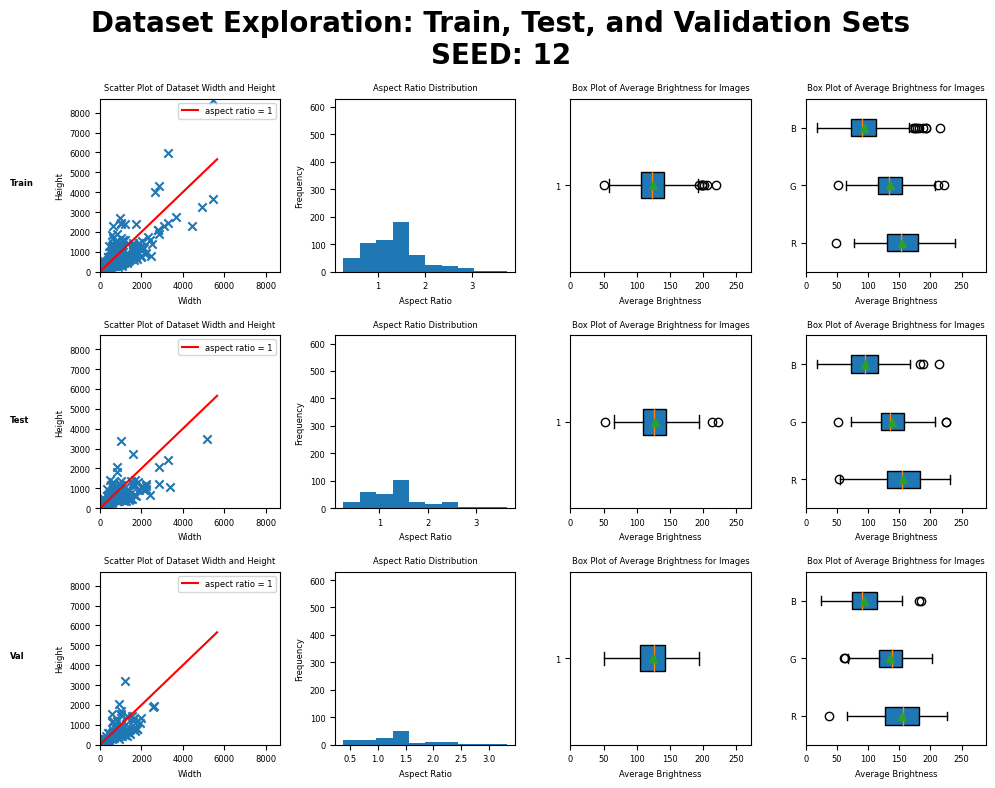

Training files: 580
Testing files: 311
Validation files: 145
Training files per class: {'BooPadPongali': 188, 'PadPakBung': 83, 'FriedKale': 178, 'MassamanGai': 131}
Testing files per class: {'FriedKale': 96, 'MassamanGai': 69, 'BooPadPongali': 96, 'PadPakBung': 50}
Validation files per class: {'FriedKale': 37, 'PadPakBung': 13, 'MassamanGai': 47, 'BooPadPongali': 48}


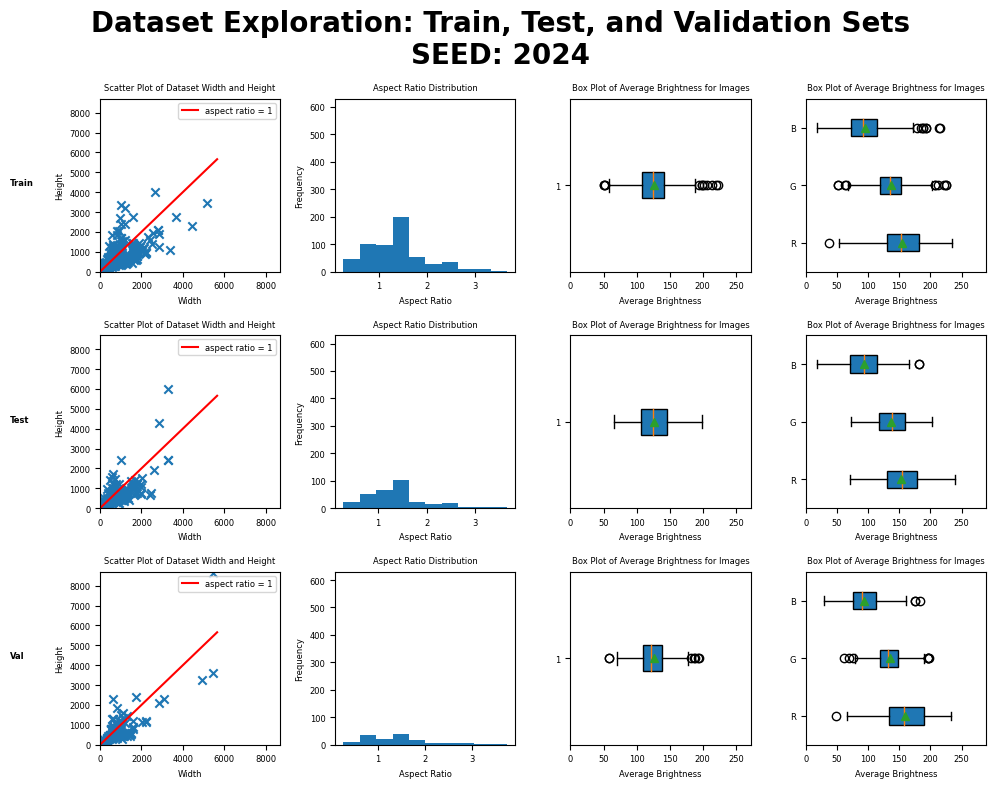

Training files: 580
Testing files: 311
Validation files: 145
Training files per class: {'BooPadPongali': 173, 'PadPakBung': 84, 'MassamanGai': 141, 'FriedKale': 182}
Testing files per class: {'PadPakBung': 39, 'FriedKale': 88, 'MassamanGai': 73, 'BooPadPongali': 111}
Validation files per class: {'PadPakBung': 23, 'BooPadPongali': 48, 'FriedKale': 41, 'MassamanGai': 33}


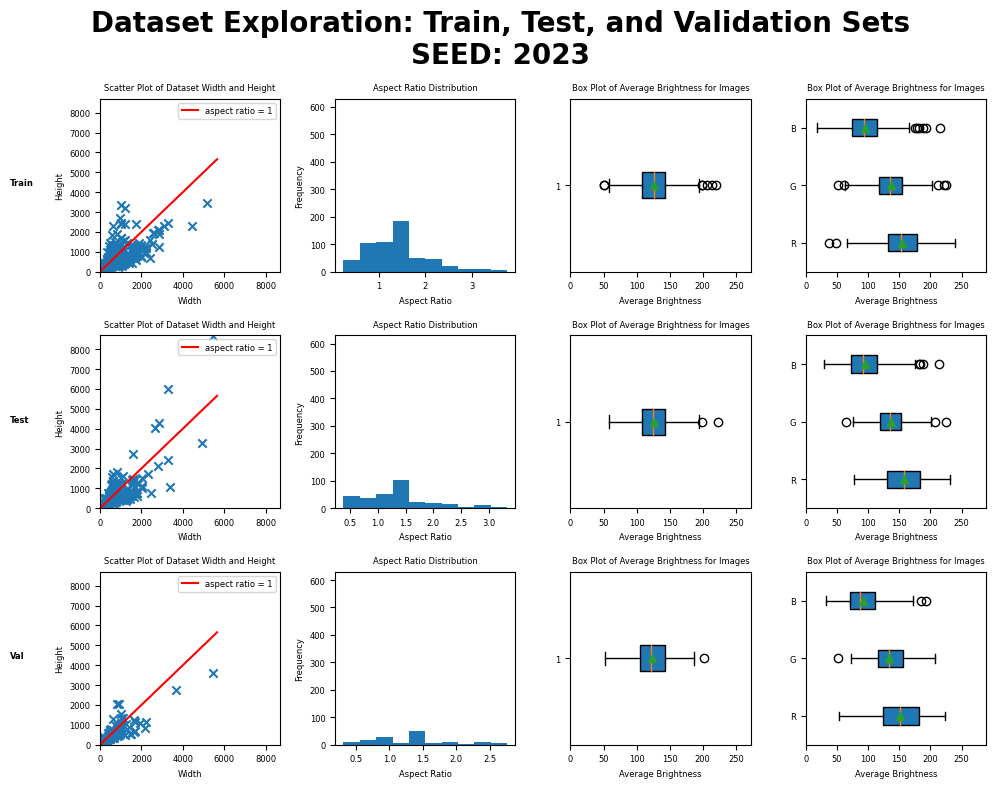

In [4]:
dataset_dir = "/content/train"
summary(dataset_dir,12)
summary(dataset_dir,2024)
summary(dataset_dir,2023)


Training files: 580
Testing files: 311
Validation files: 145
Training files per class: {'FriedKale': 180, 'MassamanGai': 138, 'BooPadPongali': 182, 'PadPakBung': 80}
Testing files per class: {'MassamanGai': 72, 'FriedKale': 94, 'BooPadPongali': 99, 'PadPakBung': 46}
Validation files per class: {'PadPakBung': 20, 'MassamanGai': 37, 'BooPadPongali': 51, 'FriedKale': 37}


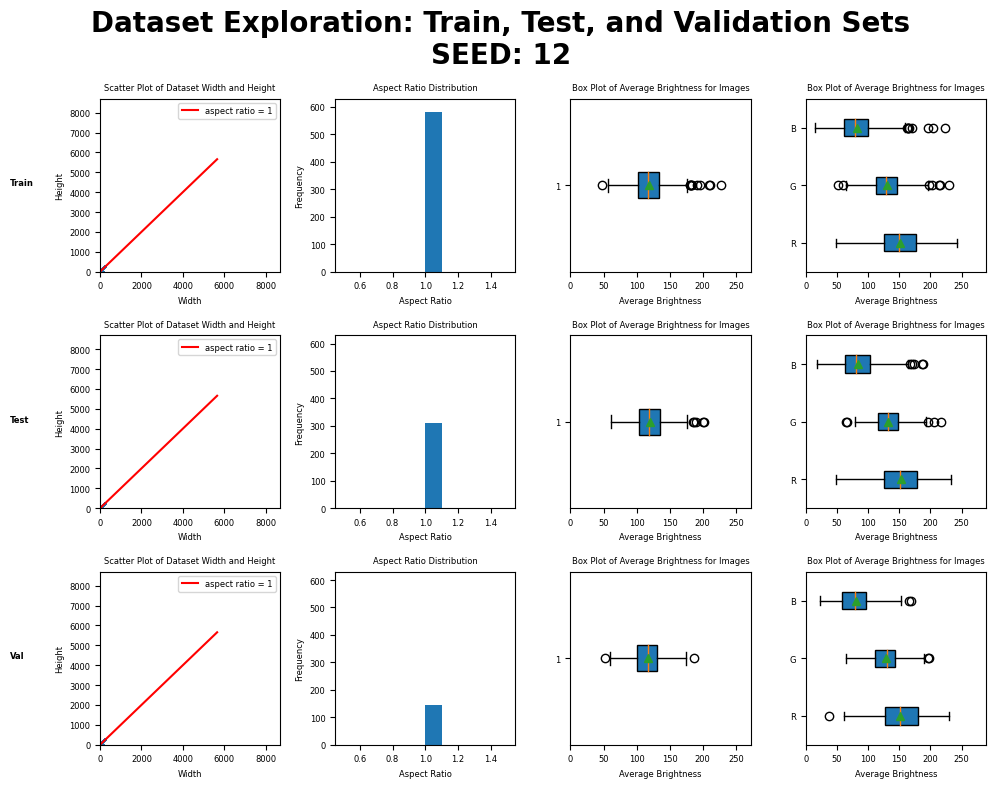

In [5]:
dataset_dir = "/content/train"
summary(dataset_dir,12,center_crop=True)

# DATA CORRECTION
- ASPECT RATIO ‚Üí CENTER CROP


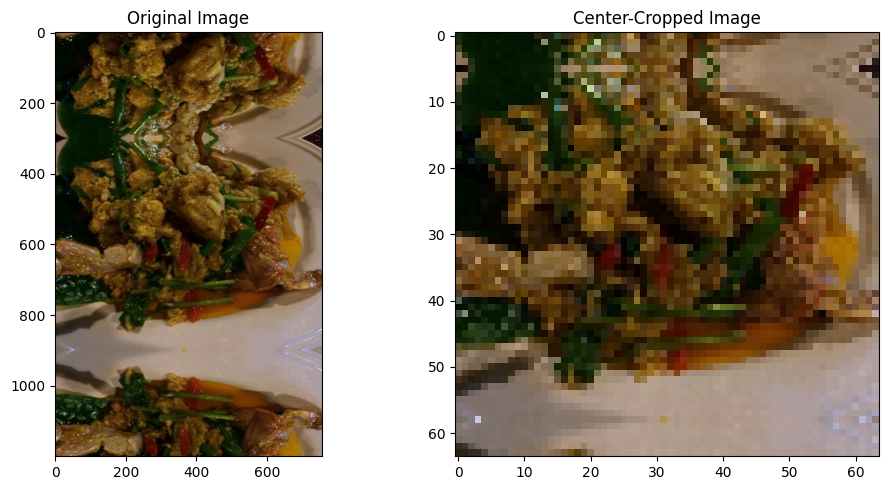

In [6]:
og_img = cv2.imread('/content/train/BooPadPongali/002.jpg')
og_img = cv2.cvtColor(og_img,cv2.COLOR_BGR2RGB)
img = center_crop_image(og_img,(64,64))
ig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
ax[0].imshow(og_img)
ax[0].set_title('Original Image')

# Display the center-cropped image
ax[1].imshow(img)
ax[1].set_title('Center-Cropped Image')


plt.tight_layout()
plt.show()

In [7]:
seed = 12
dataset_dir = "/content/train"
train_files, test_files, val_files = prepare_data(dataset_dir, seed=seed)

copy_files_to_new_folders(f'/content/seed{seed}', train_files, test_files, val_files)

Training files: 580
Testing files: 311
Validation files: 145
Training files per class: {'FriedKale': 180, 'MassamanGai': 138, 'BooPadPongali': 182, 'PadPakBung': 80}
Testing files per class: {'MassamanGai': 72, 'FriedKale': 94, 'BooPadPongali': 99, 'PadPakBung': 46}
Validation files per class: {'PadPakBung': 20, 'MassamanGai': 37, 'BooPadPongali': 51, 'FriedKale': 37}


---

# DATA PREPARATION
‡πÄ‡∏õ‡πá‡∏ô‡∏Ç‡∏±‡πâ‡∏ô‡∏ï‡∏≠‡∏ô‡∏™‡∏≥‡∏Ñ‡∏±‡∏ç‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡πÄ‡∏ï‡∏£‡∏µ‡∏¢‡∏°‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏û‡∏∑‡πà‡∏≠‡πÉ‡∏´‡πâ‡πÑ‡∏î‡πâ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏µ‡πà‡∏î‡∏µ‡πÅ‡∏•‡∏∞‡∏°‡∏µ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏´‡∏•‡∏≤‡∏Å‡∏´‡∏•‡∏≤‡∏¢‡πÄ‡∏û‡∏µ‡∏¢‡∏á‡∏û‡∏≠ ‡∏ä‡πà‡∏ß‡∏¢‡πÉ‡∏´‡πâ‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ‡πÄ‡∏£‡∏µ‡∏¢‡∏ô‡∏£‡∏π‡πâ‡πÅ‡∏•‡∏∞‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡πÑ‡∏î‡πâ‡πÅ‡∏°‡πà‡∏ô‡∏¢‡∏≥‡∏°‡∏≤‡∏Å‡∏Ç‡∏∂‡πâ‡∏ô ‡∏´‡∏ô‡∏∂‡πà‡∏á‡πÉ‡∏ô‡∏Å‡∏£‡∏∞‡∏ö‡∏ß‡∏ô‡∏Å‡∏≤‡∏£‡∏™‡∏≥‡∏Ñ‡∏±‡∏ç‡πÉ‡∏ô‡∏Ç‡∏±‡πâ‡∏ô‡∏ï‡∏≠‡∏ô‡∏Å‡∏≤‡∏£‡πÄ‡∏ï‡∏£‡∏µ‡∏¢‡∏°‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏Ñ‡∏∑‡∏≠ Data Augmentation

### Data Augmentation


In [8]:
def load_data(path,is_test=False):
    torch.manual_seed(4912)

    if is_test:
        transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
        ])
        dataset = ImageFolder(path, transform=transform)

    else:
        transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((66, 66)),
        transforms.Pad(65, padding_mode='reflect'),
        transforms.RandomAffine(degrees=15, translate=(0.05, 0.05),scale=(0.8, 1.2), shear=10),
        transforms.CenterCrop(64),
        ])
        dataset = ImageFolder(path, transform=transform)
    class_names = dataset.classes
    print("class_names",class_names)
    data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)

    print("üìÉDataset:")
    class_counts_train = [0] * len(class_names)
    for _, target in dataset:
        class_counts_train[target] += 1

    for class_name, class_count in zip(class_names, class_counts_train):
        print(f"\tNumber of images in class {class_name}: {class_count}")

    print(f"\tNumber of samples: {len(dataset)}")

    return dataset

In [9]:
train_dataset = load_data('/content/seed12/train')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)
test_dataset = load_data('/content/seed12/test',is_test=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)
val_dataset = load_data('/content/seed12/val',is_test=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)


class_names ['BooPadPongali', 'FriedKale', 'MassamanGai', 'PadPakBung']
üìÉDataset:


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


	Number of images in class BooPadPongali: 182
	Number of images in class FriedKale: 180
	Number of images in class MassamanGai: 138
	Number of images in class PadPakBung: 80
	Number of samples: 580
class_names ['BooPadPongali', 'FriedKale', 'MassamanGai', 'PadPakBung']
üìÉDataset:
	Number of images in class BooPadPongali: 99
	Number of images in class FriedKale: 94
	Number of images in class MassamanGai: 72
	Number of images in class PadPakBung: 46
	Number of samples: 311
class_names ['BooPadPongali', 'FriedKale', 'MassamanGai', 'PadPakBung']
üìÉDataset:
	Number of images in class BooPadPongali: 51
	Number of images in class FriedKale: 37
	Number of images in class MassamanGai: 37
	Number of images in class PadPakBung: 20
	Number of samples: 145


In [10]:
def imshow_grid(images, labels, class_names):
    num_images = len(images)
    num_rows = int(np.ceil(np.sqrt(num_images)))
    num_cols = int(np.ceil(num_images / num_rows))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6),dpi=100)
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            image = images[i].permute(1, 2, 0)
            label = labels[i].item()
            ax.imshow(torch.clamp(image,0,1))
            ax.set_title(class_names[label])
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

In [11]:
class_names = ['BooPadPongali', 'FriedKale', 'MassamanGai', 'PadPakBung']
batch, labels = next(iter(train_loader))
imshow_grid(batch, labels, class_names)

# MODEL ARCHITECTURE
## LeNet Model Architecture

![lenet.jpg](https://github.com/NextGen-AI-Camp/curriculum/blob/main/Week%235/CNN%232/asset/lenet.jpg?raw=true)

https://www.naukri.com/code360/library/lenet-5

LeNet ‡πÄ‡∏õ‡πá‡∏ô‡∏´‡∏ô‡∏∂‡πà‡∏á‡πÉ‡∏ô‡∏™‡∏ñ‡∏≤‡∏õ‡∏±‡∏ï‡∏¢‡∏Å‡∏£‡∏£‡∏°‡∏Ç‡∏≠‡∏á Convolutional Neural Network (CNN) ‡∏ó‡∏µ‡πà‡πÑ‡∏î‡πâ‡∏£‡∏±‡∏ö‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ô‡∏¥‡∏¢‡∏°‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡∏à‡∏î‡∏à‡∏≥‡∏†‡∏≤‡∏û ‡πÇ‡∏î‡∏¢ LeNet ‡∏ñ‡∏π‡∏Å‡∏û‡∏±‡∏í‡∏ô‡∏≤‡∏Ç‡∏∂‡πâ‡∏ô‡πÇ‡∏î‡∏¢ Yann LeCun ‡πÅ‡∏•‡∏∞‡∏Ñ‡∏ì‡∏∞‡πÉ‡∏ô‡∏õ‡∏µ 1998 ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏à‡∏≥‡πÅ‡∏ô‡∏Å‡∏ï‡∏±‡∏ß‡πÄ‡∏•‡∏Ç‡∏ó‡∏µ‡πà‡πÄ‡∏Ç‡∏µ‡∏¢‡∏ô‡∏î‡πâ‡∏ß‡∏¢‡∏•‡∏≤‡∏¢‡∏°‡∏∑‡∏≠ (MNIST dataset) ‡∏™‡∏ñ‡∏≤‡∏õ‡∏±‡∏ï‡∏¢‡∏Å‡∏£‡∏£‡∏°‡∏Ç‡∏≠‡∏á LeNet ‡∏õ‡∏£‡∏∞‡∏Å‡∏≠‡∏ö‡∏î‡πâ‡∏ß‡∏¢‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå‡∏´‡∏•‡∏≤‡∏¢‡∏ä‡∏±‡πâ‡∏ô‡∏ã‡∏∂‡πà‡∏á‡∏ó‡∏≥‡∏á‡∏≤‡∏ô‡∏£‡πà‡∏ß‡∏°‡∏Å‡∏±‡∏ô‡πÄ‡∏û‡∏∑‡πà‡∏≠‡πÅ‡∏¢‡∏Å‡∏Ñ‡∏∏‡∏ì‡∏™‡∏°‡∏ö‡∏±‡∏ï‡∏¥‡∏ó‡∏µ‡πà‡∏°‡∏µ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏™‡∏≥‡∏Ñ‡∏±‡∏ç‡∏à‡∏≤‡∏Å‡∏†‡∏≤‡∏û

### ‡πÇ‡∏Ñ‡∏£‡∏á‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Ç‡∏≠‡∏á LeNet

LeNet ‡∏õ‡∏£‡∏∞‡∏Å‡∏≠‡∏ö‡∏î‡πâ‡∏ß‡∏¢‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå‡∏´‡∏•‡∏±‡∏Å‡∏î‡∏±‡∏á‡∏ô‡∏µ‡πâ:
1. **Convolutional Layer 1 (C1)**: ‡πÉ‡∏ä‡πâ kernel weights ‡∏Ç‡∏ô‡∏≤‡∏î 5x5 ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô 6 ‡∏ï‡∏±‡∏ß ‡∏ó‡∏≥‡πÉ‡∏´‡πâ‡πÑ‡∏î‡πâ 6 feature maps ‡∏Ç‡∏ô‡∏≤‡∏î 28x28 ‡∏à‡∏∞‡∏™‡∏±‡∏á‡πÄ‡∏Å‡∏ï‡∏ß‡πà‡∏≤‡∏Ç‡∏ô‡∏≤‡∏î‡∏Ç‡∏≠‡∏á‡∏ú‡∏•‡∏•‡∏±‡∏û‡∏ò‡πå‡∏•‡∏î‡∏•‡∏á‡∏à‡∏≤‡∏Å‡∏Ç‡∏ô‡∏≤‡∏î‡∏†‡∏≤‡∏û‡∏≠‡∏¥‡∏ô‡∏û‡∏∏‡∏ó ‡πÄ‡∏ô‡∏∑‡πà‡∏≠‡∏á‡∏à‡∏≤‡∏Å‡πÑ‡∏°‡πà‡∏°‡∏µ‡∏Å‡∏≤‡∏£‡∏ó‡∏≥ padding ‡∏Å‡πà‡∏≠‡∏ô‡∏ó‡∏≥ convolution ‡πÉ‡∏ô‡∏ï‡∏±‡∏ß‡∏Å‡∏£‡∏≠‡∏á
2. **Subsampling Layer 1 (S2)**: ‡πÉ‡∏ä‡πâ‡∏Å‡∏≤‡∏£‡∏ó‡∏≥ Average Pooling ‡∏Ç‡∏ô‡∏≤‡∏î 2x2 ‡∏•‡∏î‡∏Ç‡∏ô‡∏≤‡∏î feature maps ‡∏•‡∏á‡∏Ñ‡∏£‡∏∂‡πà‡∏á‡∏´‡∏ô‡∏∂‡πà‡∏á‡πÄ‡∏õ‡πá‡∏ô 14x14
3. **Convolutional Layer 2 (C3)**: ‡πÉ‡∏ä‡πâ‡∏ï‡∏±‡∏ß‡∏Å‡∏£‡∏≠‡∏á‡∏Ç‡∏ô‡∏≤‡∏î 5x5 ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô 16 ‡∏ï‡∏±‡∏ß ‡∏ó‡∏≥‡πÉ‡∏´‡πâ‡πÑ‡∏î‡πâ 16 feature maps ‡∏Ç‡∏ô‡∏≤‡∏î 10x10 (no padding ‡πÄ‡∏ä‡πà‡∏ô‡πÄ‡∏î‡∏µ‡∏¢‡∏ß‡∏Å‡∏±‡∏ô‡∏Å‡∏±‡∏ö C1)
4. **Subsampling Layer 2 (S4)**: ‡πÉ‡∏ä‡πâ‡∏Å‡∏≤‡∏£‡∏ó‡∏≥ Average Pooling ‡∏Ç‡∏ô‡∏≤‡∏î 2x2 ‡∏•‡∏î‡∏Ç‡∏ô‡∏≤‡∏î feature maps ‡∏•‡∏á‡∏Ñ‡∏£‡∏∂‡πà‡∏á‡∏´‡∏ô‡∏∂‡πà‡∏á‡πÄ‡∏õ‡πá‡∏ô 5x5
5. **Fully Connected Layer 1 (F5)**: ‡πÅ‡∏õ‡∏•‡∏á feature maps ‡πÄ‡∏õ‡πá‡∏ô vector ‡πÅ‡∏•‡∏∞‡πÄ‡∏ä‡∏∑‡πà‡∏≠‡∏°‡∏ï‡πà‡∏≠‡πÄ‡∏Ç‡πâ‡∏≤‡∏Å‡∏±‡∏ö Neuron ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô 120 ‡∏ï‡∏±‡∏ß
6. **Fully Connected Layer 2 (F6)**: ‡πÄ‡∏ä‡∏∑‡πà‡∏≠‡∏°‡∏ï‡πà‡∏≠ Neuron ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô 120 ‡∏ï‡∏±‡∏ß‡πÑ‡∏õ‡∏¢‡∏±‡∏á Neuron ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô 84 ‡∏ï‡∏±‡∏ß
7. **Output Layer**: ‡πÉ‡∏ä‡πâ Softmax ‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏à‡∏≥‡πÅ‡∏ô‡∏Å 10 ‡∏Ñ‡∏•‡∏≤‡∏™ (‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö MNIST)

‡πÇ‡∏î‡∏¢‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡∏à‡∏≥‡∏•‡∏≠‡∏á‡πÇ‡∏°‡πÄ‡∏î‡∏•‡πÉ‡∏ô code ‡∏î‡πâ‡∏≤‡∏ô‡∏•‡πà‡∏≤‡∏á‡∏ô‡∏µ‡πâ ‡∏à‡∏∞‡πÉ‡∏ä‡πâ‡∏†‡∏≤‡∏û‡∏≠‡∏¥‡∏ô‡∏û‡∏∏‡∏ó‡∏Ç‡∏ô‡∏≤‡∏î 64x64 ‡πÄ‡∏û‡∏∑‡πà‡∏≠‡πÉ‡∏´‡πâ‡∏ß‡∏±‡∏ï‡∏ñ‡∏∏‡πÑ‡∏°‡πà‡πÄ‡∏•‡πá‡∏Å‡∏à‡∏ô‡πÄ‡∏Å‡∏¥‡∏ô‡πÑ‡∏õ
### ‡∏ú‡∏•‡∏Å‡∏£‡∏∞‡∏ó‡∏ö‡∏Ç‡∏≠‡∏á‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå‡πÅ‡∏•‡∏∞‡∏Ç‡∏ô‡∏≤‡∏î‡∏Ç‡∏≠‡∏á output channel

**‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå‡πÅ‡∏•‡∏∞‡∏Ç‡∏ô‡∏≤‡∏î‡∏Ç‡∏≠‡∏á output channel** ‡∏°‡∏µ‡∏ú‡∏•‡∏Å‡∏£‡∏∞‡∏ó‡∏ö‡∏ï‡πà‡∏≠‡∏õ‡∏£‡∏∞‡∏™‡∏¥‡∏ó‡∏ò‡∏¥‡∏†‡∏≤‡∏û‡∏Ç‡∏≠‡∏á‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏°‡∏≤‡∏Å ‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå‡∏ó‡∏µ‡πà‡∏°‡∏≤‡∏Å‡∏Ç‡∏∂‡πâ‡∏ô‡πÅ‡∏•‡∏∞‡∏Ç‡∏ô‡∏≤‡∏î‡∏Ç‡∏≠‡∏á output channel ‡πÉ‡∏ô‡πÅ‡∏ï‡πà‡∏•‡∏∞ Layer ‡∏ó‡∏µ‡πà‡∏°‡∏≤‡∏Å‡∏Ç‡∏∂‡πâ‡∏ô‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ‡∏ä‡πà‡∏ß‡∏¢‡πÉ‡∏´‡πâ‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ‡πÅ‡∏¢‡∏Å‡∏Ñ‡∏∏‡∏ì‡∏™‡∏°‡∏ö‡∏±‡∏ï‡∏¥‡∏ó‡∏µ‡πà‡∏ã‡∏±‡∏ö‡∏ã‡πâ‡∏≠‡∏ô‡∏à‡∏≤‡∏Å‡∏†‡∏≤‡∏û‡πÑ‡∏î‡πâ‡∏î‡∏µ‡∏Ç‡∏∂‡πâ‡∏ô ‡πÅ‡∏ï‡πà‡πÉ‡∏ô‡∏Ç‡∏ì‡∏∞‡πÄ‡∏î‡∏µ‡∏¢‡∏ß‡∏Å‡∏±‡∏ô‡∏Å‡πá‡∏≠‡∏≤‡∏à‡∏ó‡∏≥‡πÉ‡∏´‡πâ‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏°‡∏µ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ã‡∏±‡∏ö‡∏ã‡πâ‡∏≠‡∏ô‡∏°‡∏≤‡∏Å‡∏Ç‡∏∂‡πâ‡∏ô‡πÅ‡∏•‡∏∞‡∏ï‡πâ‡∏≠‡∏á‡πÉ‡∏ä‡πâ‡∏ó‡∏£‡∏±‡∏û‡∏¢‡∏≤‡∏Å‡∏£‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì‡∏°‡∏≤‡∏Å‡∏Ç‡∏∂‡πâ‡∏ô‡∏î‡πâ‡∏ß‡∏¢

- **‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏ï‡πâ‡∏ô‡∏Ñ‡∏ß‡∏£‡∏°‡∏µ‡∏Ç‡∏ô‡∏≤‡∏î‡πÄ‡∏•‡πá‡∏Å‡∏Å‡∏ß‡πà‡∏≤‡∏´‡∏£‡∏∑‡∏≠‡πÉ‡∏´‡∏ç‡πà‡∏Å‡∏ß‡πà‡∏≤‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå‡∏ï‡πà‡∏≠‡∏°‡∏≤‡∏´‡∏£‡∏∑‡∏≠‡πÑ‡∏°‡πà?** ‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏ï‡πâ‡∏ô‡∏Ñ‡∏ß‡∏£‡∏°‡∏µ‡∏Ç‡∏ô‡∏≤‡∏î‡πÄ‡∏•‡πá‡∏Å‡∏Å‡∏ß‡πà‡∏≤‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå‡∏ï‡πà‡∏≠‡∏°‡∏≤ ‡πÄ‡∏´‡∏ï‡∏∏‡∏ú‡∏•‡∏Ñ‡∏∑‡∏≠‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏ï‡πâ‡∏ô‡∏à‡∏∞‡∏ó‡∏≥‡∏Å‡∏≤‡∏£‡∏ï‡∏£‡∏ß‡∏à‡∏à‡∏±‡∏ö‡∏Ñ‡∏∏‡∏ì‡∏™‡∏°‡∏ö‡∏±‡∏ï‡∏¥‡∏û‡∏∑‡πâ‡∏ô‡∏ê‡∏≤‡∏ô‡πÄ‡∏ä‡πà‡∏ô ‡∏Ç‡∏≠‡∏ö ‡πÄ‡∏™‡πâ‡∏ô ‡πÅ‡∏•‡∏∞‡∏£‡∏π‡∏õ‡∏ó‡∏£‡∏á‡∏á‡πà‡∏≤‡∏¢‡πÜ ‡πÉ‡∏ô‡∏Ç‡∏ì‡∏∞‡∏ó‡∏µ‡πà‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå‡∏ï‡πà‡∏≠‡∏°‡∏≤‡∏à‡∏∞‡∏ó‡∏≥‡∏Å‡∏≤‡∏£‡∏ï‡∏£‡∏ß‡∏à‡∏à‡∏±‡∏ö‡∏Ñ‡∏∏‡∏ì‡∏™‡∏°‡∏ö‡∏±‡∏ï‡∏¥‡∏ó‡∏µ‡πà‡∏ã‡∏±‡∏ö‡∏ã‡πâ‡∏≠‡∏ô‡∏°‡∏≤‡∏Å‡∏Ç‡∏∂‡πâ‡∏ô ‡πÄ‡∏ä‡πà‡∏ô ‡∏Å‡∏≤‡∏£‡∏£‡∏ß‡∏°‡∏Å‡∏±‡∏ô‡∏Ç‡∏≠‡∏á‡∏£‡∏π‡∏õ‡πÅ‡∏ö‡∏ö‡∏û‡∏∑‡πâ‡∏ô‡∏ê‡∏≤‡∏ô‡∏à‡∏≤‡∏Å‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå‡∏Å‡πà‡∏≠‡∏ô‡∏´‡∏ô‡πâ‡∏≤ ‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏õ‡∏£‡∏∞‡∏Å‡∏≠‡∏ö‡πÄ‡∏õ‡πá‡∏ô‡πÇ‡∏Ñ‡∏£‡∏á‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Ç‡∏≠‡∏á‡∏ß‡∏±‡∏ï‡∏ñ‡∏∏ ‡∏Ç‡∏ô‡∏≤‡∏î‡∏Ç‡∏≠‡∏á output channel ‡πÉ‡∏ô‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå‡∏ï‡πà‡∏≠‡∏°‡∏≤‡∏à‡∏∂‡∏á‡∏Ñ‡∏ß‡∏£‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡∏∂‡πâ‡∏ô‡πÄ‡∏û‡∏∑‡πà‡∏≠‡πÉ‡∏´‡πâ‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ‡∏à‡∏±‡∏ö‡∏Ñ‡∏∏‡∏ì‡∏™‡∏°‡∏ö‡∏±‡∏ï‡∏¥‡∏ó‡∏µ‡πà‡∏ã‡∏±‡∏ö‡∏ã‡πâ‡∏≠‡∏ô‡πÑ‡∏î‡πâ‡∏°‡∏≤‡∏Å‡∏Ç‡∏∂‡πâ‡∏ô ‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á‡πÄ‡∏ä‡πà‡∏ô ‡πÉ‡∏ô LENET model ‡∏Ç‡∏ô‡∏≤‡∏î‡∏Ç‡∏≠‡∏á output channels ‡∏´‡∏£‡∏∑‡∏≠ convolutional nodes ‡πÉ‡∏ô‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå‡πÅ‡∏£‡∏Å‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏à‡∏≤‡∏Å 6 channels ‡πÑ‡∏õ‡πÄ‡∏õ‡πá‡∏ô 16 channels ‡πÉ‡∏ô‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå‡∏ó‡∏µ‡πà‡∏™‡∏≠‡∏á ‡∏Å‡∏≤‡∏£‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡∏∂‡πâ‡∏ô‡∏Ç‡∏≠‡∏á‡∏à‡∏≥‡∏ô‡∏ß‡∏ô channel ‡∏ô‡∏µ‡πâ‡∏à‡∏∞‡∏ä‡πà‡∏ß‡∏¢‡πÉ‡∏´‡πâ‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ‡πÅ‡∏¢‡∏Å‡∏Ñ‡∏∏‡∏ì‡∏™‡∏°‡∏ö‡∏±‡∏ï‡∏¥‡∏ó‡∏µ‡πà‡∏ã‡∏±‡∏ö‡∏ã‡πâ‡∏≠‡∏ô‡πÑ‡∏î‡πâ‡∏°‡∏≤‡∏Å‡∏Ç‡∏∂‡πâ‡∏ô ‡πÄ‡∏°‡∏∑‡πà‡∏≠‡∏ú‡πà‡∏≤‡∏ô‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå‡πÑ‡∏õ

### ‡πÄ‡∏´‡∏ï‡∏∏‡∏ú‡∏•‡∏ó‡∏µ‡πà‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏°‡∏µ‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå subsampling ‡πÄ‡∏ä‡πà‡∏ô Average / Max Pooling

‡∏Å‡∏≤‡∏£‡∏°‡∏µ‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå subsampling ‡πÄ‡∏ä‡πà‡∏ô Average / Max Pooling ‡∏°‡∏µ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏™‡∏≥‡∏Ñ‡∏±‡∏ç‡πÉ‡∏ô CNN ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏•‡∏î‡∏Ç‡∏ô‡∏≤‡∏î‡πÄ‡∏ä‡∏¥‡∏á‡∏û‡∏∑‡πâ‡∏ô‡∏ó‡∏µ‡πà‡∏Ç‡∏≠‡∏á‡πÅ‡∏ú‡∏ô‡∏ó‡∏µ‡πà‡∏Ñ‡∏∏‡∏ì‡∏•‡∏±‡∏Å‡∏©‡∏ì‡∏∞ ‡∏Å‡∏≤‡∏£‡∏•‡∏î‡∏Ç‡∏ô‡∏≤‡∏î‡∏ô‡∏µ‡πâ‡∏ä‡πà‡∏ß‡∏¢‡πÉ‡∏ô:
   - **‡∏Å‡∏≤‡∏£‡∏•‡∏î‡∏°‡∏¥‡∏ï‡∏¥‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡∏°‡∏ß‡∏•‡∏ú‡∏•**: ‡∏•‡∏î‡∏†‡∏≤‡∏£‡∏∞‡∏Å‡∏≤‡∏£‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì‡πÅ‡∏•‡∏∞‡∏Å‡∏≤‡∏£‡πÉ‡∏ä‡πâ‡∏´‡∏ô‡πà‡∏ß‡∏¢‡∏Ñ‡∏ß‡∏≤‡∏°‡∏à‡∏≥
   - **‡πÄ‡∏ó‡∏Ñ‡∏ô‡∏¥‡∏Ñ‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡∏°‡∏ß‡∏•‡∏ú‡∏•‡πÅ‡∏ö‡∏ö‡∏û‡∏µ‡∏£‡∏∞‡∏°‡∏¥‡∏î**: ‡∏Ñ‡∏•‡πâ‡∏≤‡∏¢‡∏Å‡∏±‡∏ö‡πÄ‡∏ó‡∏Ñ‡∏ô‡∏¥‡∏Ñ‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏û‡∏µ‡∏£‡∏∞‡∏°‡∏¥‡∏î‡∏†‡∏≤‡∏û ‡πÇ‡∏î‡∏¢‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏±‡∏ö‡∏•‡∏î‡∏Ç‡∏ô‡∏≤‡∏î‡∏†‡∏≤‡∏û‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏ä‡πà‡∏ß‡∏¢‡∏•‡∏î‡∏Ç‡∏ô‡∏≤‡∏î‡∏ß‡∏±‡∏ï‡∏ñ‡∏∏ ‡∏ó‡∏≥‡πÉ‡∏´‡πâ‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ‡∏ï‡∏£‡∏ß‡∏à‡∏à‡∏±‡∏ö‡∏ß‡∏±‡∏ï‡∏ñ‡∏∏‡∏ó‡∏µ‡πà‡∏°‡∏µ‡∏Ç‡∏ô‡∏≤‡∏î‡πÉ‡∏´‡∏ç‡πà‡∏Ç‡∏∂‡πâ‡∏ô‡πÑ‡∏î‡πâ‡∏î‡πâ‡∏ß‡∏¢‡∏ï‡∏±‡∏ß‡∏Å‡∏£‡∏≠‡∏á‡∏´‡∏£‡∏∑‡∏≠ Kernel weights ‡∏Ç‡∏ô‡∏≤‡∏î‡πÄ‡∏ó‡πà‡∏≤‡πÄ‡∏î‡∏¥‡∏°   ‡∏ä‡πà‡∏ß‡∏¢‡πÉ‡∏´‡πâ‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ‡∏õ‡∏£‡∏∞‡∏°‡∏ß‡∏•‡∏ú‡∏•‡∏Ñ‡∏∏‡∏ì‡∏•‡∏±‡∏Å‡∏©‡∏ì‡∏∞‡∏ó‡∏µ‡πà‡∏°‡∏µ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏•‡∏∞‡πÄ‡∏≠‡∏µ‡∏¢‡∏î‡πÅ‡∏•‡∏∞‡∏Ç‡∏ô‡∏≤‡∏î‡∏ó‡∏µ‡πà‡πÅ‡∏ï‡∏Å‡∏ï‡πà‡∏≤‡∏á‡∏Å‡∏±‡∏ô‡πÑ‡∏î‡πâ ‡πÇ‡∏î‡∏¢‡πÑ‡∏°‡πà‡πÄ‡∏™‡∏µ‡∏¢‡πÄ‡∏ß‡∏•‡∏≤‡∏õ‡∏£‡∏∞‡∏°‡∏ß‡∏•‡∏ú‡∏•‡∏°‡∏≤‡∏Å ‡∏ô‡∏µ‡πà‡πÄ‡∏õ‡πá‡∏ô‡∏õ‡∏£‡∏∞‡πÇ‡∏¢‡∏ä‡∏ô‡πå‡πÇ‡∏î‡∏¢‡πÄ‡∏â‡∏û‡∏≤‡∏∞‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡∏£‡∏±‡∏ö‡∏£‡∏π‡πâ‡∏ß‡∏±‡∏ï‡∏ñ‡∏∏‡πÉ‡∏ô‡∏Ç‡∏ô‡∏≤‡∏î‡πÅ‡∏•‡∏∞‡∏ï‡∏≥‡πÅ‡∏´‡∏ô‡πà‡∏á‡∏ó‡∏µ‡πà‡πÅ‡∏ï‡∏Å‡∏ï‡πà‡∏≤‡∏á‡∏Å‡∏±‡∏ô‡∏†‡∏≤‡∏¢‡πÉ‡∏ô‡∏†‡∏≤‡∏û
   - **‡∏Å‡∏≤‡∏£‡∏¢‡∏∑‡∏î‡∏´‡∏¢‡∏∏‡πà‡∏ô‡∏ï‡πà‡∏≠‡∏Å‡∏≤‡∏£‡πÄ‡∏õ‡∏•‡∏µ‡πà‡∏¢‡∏ô‡πÅ‡∏õ‡∏•‡∏á**: ‡∏Å‡∏≤‡∏£‡∏™‡∏£‡∏∏‡∏õ‡∏Ñ‡∏∏‡∏ì‡∏•‡∏±‡∏Å‡∏©‡∏ì‡∏∞‡πÄ‡∏ä‡∏¥‡∏á‡∏™‡∏ñ‡∏¥‡∏ï‡∏¥ ‡πÄ‡∏ä‡πà‡∏ô Average/Max pooling ‡πÉ‡∏ô‡∏û‡∏∑‡πâ‡∏ô‡∏ó‡∏µ‡πà‡∏¢‡πà‡∏≠‡∏¢ ‡∏ä‡πà‡∏ß‡∏¢‡πÉ‡∏´‡πâ‡∏•‡∏î‡∏ú‡∏•‡∏Å‡∏£‡∏∞‡∏ó‡∏ö‡∏ï‡πà‡∏≠‡∏Å‡∏≤‡∏£‡πÄ‡∏õ‡∏•‡∏µ‡πà‡∏¢‡∏ô‡πÅ‡∏õ‡∏•‡∏á‡πÉ‡∏ô‡∏û‡∏∑‡πâ‡∏ô‡∏ó‡∏µ‡πà‡∏¢‡πà‡∏≠‡∏¢‡∏ô‡∏±‡πâ‡∏ô ‡πÅ‡∏•‡∏∞‡∏ä‡πà‡∏ß‡∏¢‡πÉ‡∏´‡πâ‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ó‡∏ô‡∏ó‡∏≤‡∏ô‡∏ï‡πà‡∏≠‡∏Å‡∏≤‡∏£‡πÅ‡∏õ‡∏•‡πÅ‡∏•‡∏∞‡∏Å‡∏≤‡∏£‡∏ö‡∏¥‡∏î‡πÄ‡∏ö‡∏∑‡∏≠‡∏ô‡πÄ‡∏•‡πá‡∏Å‡∏ô‡πâ‡∏≠‡∏¢‡πÉ‡∏ô‡∏†‡∏≤‡∏û

‡πÇ‡∏î‡∏¢‡∏™‡∏£‡∏∏‡∏õ ‡∏™‡∏ñ‡∏≤‡∏õ‡∏±‡∏ï‡∏¢‡∏Å‡∏£‡∏£‡∏° LeNet ‡∏ñ‡∏π‡∏Å‡∏≠‡∏≠‡∏Å‡πÅ‡∏ö‡∏ö‡∏î‡πâ‡∏ß‡∏¢‡∏Å‡∏≤‡∏£‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏à‡∏≥‡∏ô‡∏ß‡∏ô output channels ‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏Ñ‡πà‡∏≠‡∏¢‡πÄ‡∏õ‡πá‡∏ô‡∏Ñ‡πà‡∏≠‡∏¢‡πÑ‡∏õ‡πÅ‡∏•‡∏∞‡∏Å‡∏≤‡∏£‡∏•‡∏î‡∏Ç‡∏ô‡∏≤‡∏î‡∏Ç‡∏≠‡∏á‡πÅ‡∏ú‡∏ô‡∏ó‡∏µ‡πà‡∏Ñ‡∏∏‡∏ì‡∏•‡∏±‡∏Å‡∏©‡∏ì‡∏∞‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏à‡∏±‡∏ö‡∏Ñ‡∏∏‡∏ì‡∏•‡∏±‡∏Å‡∏©‡∏ì‡∏∞‡∏ó‡∏µ‡πà‡∏ã‡∏±‡∏ö‡∏ã‡πâ‡∏≠‡∏ô‡πÑ‡∏î‡πâ‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏°‡∏µ‡∏õ‡∏£‡∏∞‡∏™‡∏¥‡∏ó‡∏ò‡∏¥‡∏†‡∏≤‡∏û ‡∏Å‡∏≤‡∏£‡πÉ‡∏ä‡πâ‡∏´‡∏•‡∏≤‡∏Å‡∏´‡∏•‡∏≤‡∏¢‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå‡∏ä‡πà‡∏ß‡∏¢‡πÉ‡∏´‡πâ‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏à‡∏±‡∏î‡∏Å‡∏≤‡∏£‡∏Å‡∏±‡∏ö‡∏†‡∏≤‡∏û‡∏ó‡∏µ‡πà‡∏°‡∏µ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏•‡∏∞‡πÄ‡∏≠‡∏µ‡∏¢‡∏î‡πÅ‡∏•‡∏∞‡∏Ç‡∏ô‡∏≤‡∏î‡∏ó‡∏µ‡πà‡πÅ‡∏ï‡∏Å‡∏ï‡πà‡∏≤‡∏á‡∏Å‡∏±‡∏ô‡πÑ‡∏î‡πâ ‡∏ã‡∏∂‡πà‡∏á‡∏ä‡πà‡∏ß‡∏¢‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ó‡∏ô‡∏ó‡∏≤‡∏ô‡πÅ‡∏•‡∏∞‡∏õ‡∏£‡∏∞‡∏™‡∏¥‡∏ó‡∏ò‡∏¥‡∏†‡∏≤‡∏û‡∏Ç‡∏≠‡∏á‡πÇ‡∏°‡πÄ‡∏î‡∏•

### ‡πÄ‡∏´‡∏ï‡∏∏‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡πÑ‡∏°‡πà‡πÉ‡∏™‡πà Activation Function ‡∏ó‡∏µ‡πà Output Node ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏õ‡∏±‡∏ç‡∏´‡∏≤ Multiclass Classification

‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏õ‡∏±‡∏ç‡∏´‡∏≤ Multi-class classification ‡πÄ‡∏£‡∏≤‡πÄ‡∏•‡∏∑‡∏≠‡∏Å‡πÉ‡∏ä‡πâ Loss ‡πÄ‡∏õ‡πá‡∏ô
nn.CrossEntropyLoss ‡πÉ‡∏ô PyTorch ‡∏ã‡∏∂‡πà‡∏á‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£‡∏ô‡∏≥‡πÄ‡∏Ç‡πâ‡∏≤‡∏Ñ‡πà‡∏≤ output logits ‡πÇ‡∏î‡∏¢‡∏°‡∏µ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô softmax ‡πÅ‡∏•‡∏∞ negative log-likelihood ‡∏£‡∏ß‡∏°‡πÑ‡∏ß‡πâ‡∏†‡∏≤‡∏¢‡πÉ‡∏ô ‡πÇ‡∏î‡∏¢ Softmax: ‡∏à‡∏∞‡∏ó‡∏≥‡∏Å‡∏≤‡∏£‡πÅ‡∏õ‡∏•‡∏á logits ‡πÄ‡∏õ‡πá‡∏ô‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ô‡πà‡∏≤‡∏à‡∏∞‡πÄ‡∏õ‡πá‡∏ô‡πÉ‡∏´‡πâ‡∏Å‡∏±‡∏ö Negative Log-Likelihood Loss ‡πÄ‡∏û‡∏∑‡πà‡∏≠‡πÄ‡∏•‡∏µ‡πà‡∏¢‡∏á‡∏õ‡∏±‡∏ç‡∏´‡∏≤‡∏à‡∏≤‡∏Å floating point precision ‡πÅ‡∏•‡∏∞‡πÇ‡∏≠‡∏Å‡∏≤‡∏£‡∏Å‡∏≤‡∏£‡πÄ‡∏Å‡∏¥‡∏î underflow ‡∏´‡∏£‡∏∑‡∏≠ overflow error.


In [47]:
import torch
import torch.nn as nn

class FoodFounder(nn.Module):
    def __init__(self, input_size=(3, 64, 64)):
        super(FoodFounder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=input_size[0], out_channels=18, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=18, out_channels=8, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(self._get_input_size_fc1(input_size), 120)
        self.relu4 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(120, 84)
        self.relu5 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(84, 4)

    def _get_input_size_fc1(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.conv1(x)
            x = self.relu1(x)
            x = self.conv2(x)
            x = self.relu2(x)
            x = self.pool1(x)
            x = self.dropout1(x)

            x = self.conv3(x)
            x = self.relu3(x)
            x = self.pool2(x)
            x = self.dropout2(x)

            x = self.flatten(x)
        return x.size(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout3(x)

        x = self.fc2(x)
        x = self.relu5(x)
        x = self.dropout4(x)

        x = self.fc3(x)
        return x


## Train
### ‡∏Å‡∏£‡∏∞‡∏ö‡∏ß‡∏ô‡∏Å‡∏≤‡∏£‡∏ù‡∏∂‡∏Å‡πÇ‡∏°‡πÄ‡∏î‡∏•


In [48]:
def train(model, opt, loss_fn, train_loader, test_loader, epochs=10, checkpoint_path=None, device='cpu'):
    print("ü§ñTraining on", device)
    model = model.to(device)

    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in range(epochs):
        model.train()
        train_bar = tqdm(train_loader, desc=f'üöÄTraining Epoch [{epoch+1}/{epochs}]', unit='batch')

        total_train_loss = 0
        total_train_correct = 0

        for images, labels in train_bar:
            images = images.to(device)
            labels = labels.to(device)

            opt.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)
            loss.backward()
            opt.step()

            total_train_loss += loss.item()
            predicted = torch.argmax(nn.functional.softmax(output, dim=1), dim=1)
            total_train_correct += (predicted == labels).sum().item()

            train_bar.set_postfix(loss=loss.item())

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_correct / len(train_loader.dataset)

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)

        model.eval()
        test_bar = tqdm(test_loader, desc='üìÑTesting', unit='batch')

        total_test_loss = 0
        total_test_correct = 0

        with torch.no_grad():
            for images, labels in test_bar:
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                loss = loss_fn(output, labels)

                total_test_loss += loss.item()
                predicted = torch.argmax(nn.functional.softmax(output, dim=1), dim=1)
                total_test_correct += (predicted == labels).sum().item()

                test_bar.set_postfix(loss=loss.item())

        avg_test_loss = total_test_loss / len(test_loader)
        avg_test_acc = total_test_correct / len(test_loader.dataset)

        history['test_loss'].append(avg_test_loss)
        history['test_acc'].append(avg_test_acc)

        print(f"Summary :")
        print(f"\tTrain \tavg_loss: {avg_train_loss:.4f} \t| avg_acc: {avg_train_acc:.4f}")
        print(f"\tTest \tavg_loss: {avg_test_loss:.4f} \t| avg_acc: {avg_test_acc:.4f}")
        print()

        if checkpoint_path:
            torch.save(model.state_dict(), f"{checkpoint_path}_epoch_{epoch+1}.pth")

    return history


In [50]:
model = FoodFounder()
opt = torch.optim.Adam(model.parameters(), lr=0.0015)
loss_fn = nn.CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("ü§ñ Training on", device)
history = train(model, opt, loss_fn, train_loader, test_loader, epochs=100, device='cuda')

# Plotting loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['test_acc'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.show()


ü§ñ Training on cuda
ü§ñTraining on cuda


üöÄTraining Epoch [1/100]:   0%|          | 0/37 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 10.05batch/s, loss=1.33]


Summary :
	Train 	avg_loss: 1.3664 	| avg_acc: 0.2621
	Test 	avg_loss: 1.3368 	| avg_acc: 0.3923



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.97batch/s, loss=1.04]


Summary :
	Train 	avg_loss: 1.3191 	| avg_acc: 0.3155
	Test 	avg_loss: 1.1595 	| avg_acc: 0.4952



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 10.17batch/s, loss=1.15]


Summary :
	Train 	avg_loss: 1.1516 	| avg_acc: 0.4810
	Test 	avg_loss: 1.0156 	| avg_acc: 0.5338



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.56batch/s, loss=1.32]


Summary :
	Train 	avg_loss: 1.0273 	| avg_acc: 0.4862
	Test 	avg_loss: 1.0601 	| avg_acc: 0.3859



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.86batch/s, loss=0.699]


Summary :
	Train 	avg_loss: 0.9478 	| avg_acc: 0.4931
	Test 	avg_loss: 0.8867 	| avg_acc: 0.5691



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.26batch/s, loss=0.717]


Summary :
	Train 	avg_loss: 0.9426 	| avg_acc: 0.5379
	Test 	avg_loss: 0.9070 	| avg_acc: 0.4180



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.08batch/s, loss=0.768]


Summary :
	Train 	avg_loss: 0.8947 	| avg_acc: 0.5362
	Test 	avg_loss: 0.8380 	| avg_acc: 0.5241



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.36batch/s, loss=0.691]


Summary :
	Train 	avg_loss: 0.9038 	| avg_acc: 0.5224
	Test 	avg_loss: 0.8473 	| avg_acc: 0.5691



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  8.83batch/s, loss=0.768]


Summary :
	Train 	avg_loss: 0.9039 	| avg_acc: 0.5483
	Test 	avg_loss: 0.8812 	| avg_acc: 0.5563



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.83batch/s, loss=0.897]


Summary :
	Train 	avg_loss: 0.8662 	| avg_acc: 0.5362
	Test 	avg_loss: 0.8475 	| avg_acc: 0.5756



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 10.29batch/s, loss=0.971]


Summary :
	Train 	avg_loss: 0.8260 	| avg_acc: 0.5552
	Test 	avg_loss: 0.8493 	| avg_acc: 0.5466



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 10.45batch/s, loss=0.778]


Summary :
	Train 	avg_loss: 0.8354 	| avg_acc: 0.5707
	Test 	avg_loss: 0.8298 	| avg_acc: 0.5884



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.54batch/s, loss=0.745]


Summary :
	Train 	avg_loss: 0.8465 	| avg_acc: 0.5672
	Test 	avg_loss: 0.8483 	| avg_acc: 0.5048



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.25batch/s, loss=0.701]


Summary :
	Train 	avg_loss: 0.8096 	| avg_acc: 0.5638
	Test 	avg_loss: 0.7939 	| avg_acc: 0.5788



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 10.48batch/s, loss=0.672]


Summary :
	Train 	avg_loss: 0.8214 	| avg_acc: 0.5517
	Test 	avg_loss: 0.7959 	| avg_acc: 0.5531



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.35batch/s, loss=0.645]


Summary :
	Train 	avg_loss: 0.8318 	| avg_acc: 0.5483
	Test 	avg_loss: 0.7969 	| avg_acc: 0.5756



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.22batch/s, loss=0.702]


Summary :
	Train 	avg_loss: 0.8458 	| avg_acc: 0.5534
	Test 	avg_loss: 0.8116 	| avg_acc: 0.5691



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.74batch/s, loss=0.928]


Summary :
	Train 	avg_loss: 0.8354 	| avg_acc: 0.5500
	Test 	avg_loss: 0.8643 	| avg_acc: 0.5723



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.53batch/s, loss=1.02]


Summary :
	Train 	avg_loss: 0.8095 	| avg_acc: 0.5379
	Test 	avg_loss: 0.9252 	| avg_acc: 0.5305



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 10.10batch/s, loss=0.891]


Summary :
	Train 	avg_loss: 0.8609 	| avg_acc: 0.5552
	Test 	avg_loss: 0.7985 	| avg_acc: 0.5788



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 10.02batch/s, loss=0.622]


Summary :
	Train 	avg_loss: 0.8111 	| avg_acc: 0.5897
	Test 	avg_loss: 0.7881 	| avg_acc: 0.5691



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.64batch/s, loss=0.674]


Summary :
	Train 	avg_loss: 0.8246 	| avg_acc: 0.5121
	Test 	avg_loss: 0.7865 	| avg_acc: 0.5498



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.74batch/s, loss=0.681]


Summary :
	Train 	avg_loss: 0.8055 	| avg_acc: 0.5293
	Test 	avg_loss: 0.8034 	| avg_acc: 0.5595



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.82batch/s, loss=0.667]


Summary :
	Train 	avg_loss: 0.8196 	| avg_acc: 0.5724
	Test 	avg_loss: 0.7880 	| avg_acc: 0.5498



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.41batch/s, loss=1.09]


Summary :
	Train 	avg_loss: 0.8034 	| avg_acc: 0.5397
	Test 	avg_loss: 0.7781 	| avg_acc: 0.5884



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  8.98batch/s, loss=0.744]


Summary :
	Train 	avg_loss: 0.7837 	| avg_acc: 0.5586
	Test 	avg_loss: 0.8397 	| avg_acc: 0.5595



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.16batch/s, loss=0.867]


Summary :
	Train 	avg_loss: 0.7807 	| avg_acc: 0.5879
	Test 	avg_loss: 0.7876 	| avg_acc: 0.6013



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.07batch/s, loss=0.632]


Summary :
	Train 	avg_loss: 0.8417 	| avg_acc: 0.5431
	Test 	avg_loss: 0.7725 	| avg_acc: 0.5949



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 10.42batch/s, loss=0.74]


Summary :
	Train 	avg_loss: 0.7835 	| avg_acc: 0.5741
	Test 	avg_loss: 0.8112 	| avg_acc: 0.5756



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.64batch/s, loss=0.687]


Summary :
	Train 	avg_loss: 0.7827 	| avg_acc: 0.5621
	Test 	avg_loss: 0.7980 	| avg_acc: 0.5852



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.67batch/s, loss=0.708]


Summary :
	Train 	avg_loss: 0.7475 	| avg_acc: 0.5793
	Test 	avg_loss: 0.7817 	| avg_acc: 0.5659



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.67batch/s, loss=0.597]


Summary :
	Train 	avg_loss: 0.7589 	| avg_acc: 0.5862
	Test 	avg_loss: 0.7492 	| avg_acc: 0.6045



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.24batch/s, loss=1.64]


Summary :
	Train 	avg_loss: 0.7680 	| avg_acc: 0.5983
	Test 	avg_loss: 0.8231 	| avg_acc: 0.5756



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  8.86batch/s, loss=0.82]


Summary :
	Train 	avg_loss: 0.8056 	| avg_acc: 0.5638
	Test 	avg_loss: 0.7821 	| avg_acc: 0.5788



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 10.10batch/s, loss=0.742]


Summary :
	Train 	avg_loss: 0.8085 	| avg_acc: 0.5810
	Test 	avg_loss: 0.7795 	| avg_acc: 0.5820



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.48batch/s, loss=0.681]


Summary :
	Train 	avg_loss: 0.7606 	| avg_acc: 0.5724
	Test 	avg_loss: 0.7901 	| avg_acc: 0.6013



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 10.39batch/s, loss=0.895]


Summary :
	Train 	avg_loss: 0.7672 	| avg_acc: 0.5845
	Test 	avg_loss: 0.7642 	| avg_acc: 0.5981



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.92batch/s, loss=0.74]


Summary :
	Train 	avg_loss: 0.7316 	| avg_acc: 0.5879
	Test 	avg_loss: 0.7846 	| avg_acc: 0.5820



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  8.98batch/s, loss=0.371]


Summary :
	Train 	avg_loss: 0.7133 	| avg_acc: 0.6155
	Test 	avg_loss: 0.7468 	| avg_acc: 0.5884



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  8.84batch/s, loss=0.669]


Summary :
	Train 	avg_loss: 0.7756 	| avg_acc: 0.5741
	Test 	avg_loss: 0.7669 	| avg_acc: 0.5852



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.90batch/s, loss=0.645]


Summary :
	Train 	avg_loss: 0.8015 	| avg_acc: 0.5638
	Test 	avg_loss: 0.7634 	| avg_acc: 0.5723



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.91batch/s, loss=1.03]


Summary :
	Train 	avg_loss: 0.7654 	| avg_acc: 0.5828
	Test 	avg_loss: 0.7527 	| avg_acc: 0.5852



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.34batch/s, loss=0.638]


Summary :
	Train 	avg_loss: 0.7323 	| avg_acc: 0.5759
	Test 	avg_loss: 0.7761 	| avg_acc: 0.5820



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 10.02batch/s, loss=0.703]


Summary :
	Train 	avg_loss: 0.7456 	| avg_acc: 0.5759
	Test 	avg_loss: 0.7379 	| avg_acc: 0.5949



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  8.59batch/s, loss=0.675]


Summary :
	Train 	avg_loss: 0.7137 	| avg_acc: 0.5966
	Test 	avg_loss: 0.7700 	| avg_acc: 0.5884



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  8.92batch/s, loss=0.602]


Summary :
	Train 	avg_loss: 0.6951 	| avg_acc: 0.6155
	Test 	avg_loss: 0.7544 	| avg_acc: 0.6045



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.02batch/s, loss=1.02]


Summary :
	Train 	avg_loss: 0.7396 	| avg_acc: 0.5793
	Test 	avg_loss: 0.7543 	| avg_acc: 0.6013



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.55batch/s, loss=0.553]


Summary :
	Train 	avg_loss: 0.7118 	| avg_acc: 0.6138
	Test 	avg_loss: 0.7369 	| avg_acc: 0.6174



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.11batch/s, loss=0.577]


Summary :
	Train 	avg_loss: 0.7423 	| avg_acc: 0.6086
	Test 	avg_loss: 0.7650 	| avg_acc: 0.6077



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.81batch/s, loss=1.22]


Summary :
	Train 	avg_loss: 0.7253 	| avg_acc: 0.6103
	Test 	avg_loss: 0.7883 	| avg_acc: 0.5788



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  8.67batch/s, loss=0.639]


Summary :
	Train 	avg_loss: 0.7282 	| avg_acc: 0.6155
	Test 	avg_loss: 0.7740 	| avg_acc: 0.5949



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.11batch/s, loss=0.43]


Summary :
	Train 	avg_loss: 0.7412 	| avg_acc: 0.5983
	Test 	avg_loss: 0.7248 	| avg_acc: 0.6238



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.08batch/s, loss=0.427]


Summary :
	Train 	avg_loss: 0.7310 	| avg_acc: 0.5983
	Test 	avg_loss: 0.7979 	| avg_acc: 0.6077



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.56batch/s, loss=0.723]


Summary :
	Train 	avg_loss: 0.7270 	| avg_acc: 0.5966
	Test 	avg_loss: 0.7517 	| avg_acc: 0.6238



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.19batch/s, loss=0.591]


Summary :
	Train 	avg_loss: 0.7242 	| avg_acc: 0.5845
	Test 	avg_loss: 0.7214 	| avg_acc: 0.5788



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.55batch/s, loss=0.777]


Summary :
	Train 	avg_loss: 0.7153 	| avg_acc: 0.6086
	Test 	avg_loss: 0.7847 	| avg_acc: 0.5852



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 10.22batch/s, loss=0.417]


Summary :
	Train 	avg_loss: 0.7261 	| avg_acc: 0.6276
	Test 	avg_loss: 0.7746 	| avg_acc: 0.5852



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 10.79batch/s, loss=0.811]


Summary :
	Train 	avg_loss: 0.6606 	| avg_acc: 0.6397
	Test 	avg_loss: 0.7322 	| avg_acc: 0.6688



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 10.41batch/s, loss=0.688]


Summary :
	Train 	avg_loss: 0.7150 	| avg_acc: 0.6276
	Test 	avg_loss: 0.7486 	| avg_acc: 0.6077



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.93batch/s, loss=0.482]


Summary :
	Train 	avg_loss: 0.7215 	| avg_acc: 0.6259
	Test 	avg_loss: 0.7044 	| avg_acc: 0.6302



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  8.93batch/s, loss=0.644]


Summary :
	Train 	avg_loss: 0.6888 	| avg_acc: 0.6293
	Test 	avg_loss: 0.8791 	| avg_acc: 0.5659



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.92batch/s, loss=0.565]


Summary :
	Train 	avg_loss: 0.7262 	| avg_acc: 0.6172
	Test 	avg_loss: 0.7273 	| avg_acc: 0.6431



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.25batch/s, loss=0.492]


Summary :
	Train 	avg_loss: 0.7432 	| avg_acc: 0.6000
	Test 	avg_loss: 0.7565 	| avg_acc: 0.6206



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.80batch/s, loss=1.03]


Summary :
	Train 	avg_loss: 0.6929 	| avg_acc: 0.6431
	Test 	avg_loss: 0.7349 	| avg_acc: 0.6302



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  8.53batch/s, loss=0.632]


Summary :
	Train 	avg_loss: 0.6811 	| avg_acc: 0.6483
	Test 	avg_loss: 0.7127 	| avg_acc: 0.6495



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 10.13batch/s, loss=0.754]


Summary :
	Train 	avg_loss: 0.7431 	| avg_acc: 0.6431
	Test 	avg_loss: 0.7219 	| avg_acc: 0.6527



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 10.17batch/s, loss=1.07]


Summary :
	Train 	avg_loss: 0.6787 	| avg_acc: 0.6759
	Test 	avg_loss: 0.8237 	| avg_acc: 0.5981



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.10batch/s, loss=0.712]


Summary :
	Train 	avg_loss: 0.7088 	| avg_acc: 0.6103
	Test 	avg_loss: 0.7069 	| avg_acc: 0.6495



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  8.83batch/s, loss=0.502]


Summary :
	Train 	avg_loss: 0.6530 	| avg_acc: 0.6517
	Test 	avg_loss: 0.7041 	| avg_acc: 0.6495



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.26batch/s, loss=0.547]


Summary :
	Train 	avg_loss: 0.7082 	| avg_acc: 0.6534
	Test 	avg_loss: 0.7761 	| avg_acc: 0.6656



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  8.92batch/s, loss=0.582]


Summary :
	Train 	avg_loss: 0.7387 	| avg_acc: 0.6241
	Test 	avg_loss: 0.7132 	| avg_acc: 0.6720



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.36batch/s, loss=0.434]


Summary :
	Train 	avg_loss: 0.7187 	| avg_acc: 0.6155
	Test 	avg_loss: 0.6853 	| avg_acc: 0.6945



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  8.48batch/s, loss=0.46]


Summary :
	Train 	avg_loss: 0.6697 	| avg_acc: 0.6552
	Test 	avg_loss: 0.6744 	| avg_acc: 0.6913



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  8.64batch/s, loss=0.785]


Summary :
	Train 	avg_loss: 0.6668 	| avg_acc: 0.6552
	Test 	avg_loss: 0.7498 	| avg_acc: 0.6013



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.46batch/s, loss=0.569]


Summary :
	Train 	avg_loss: 0.6831 	| avg_acc: 0.6690
	Test 	avg_loss: 0.7483 	| avg_acc: 0.6463



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.66batch/s, loss=0.687]


Summary :
	Train 	avg_loss: 0.6831 	| avg_acc: 0.6172
	Test 	avg_loss: 0.6748 	| avg_acc: 0.6945



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.90batch/s, loss=0.461]


Summary :
	Train 	avg_loss: 0.6238 	| avg_acc: 0.6845
	Test 	avg_loss: 0.6971 	| avg_acc: 0.6592



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.39batch/s, loss=0.548]


Summary :
	Train 	avg_loss: 0.6830 	| avg_acc: 0.6638
	Test 	avg_loss: 0.6780 	| avg_acc: 0.6720



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.98batch/s, loss=0.588]


Summary :
	Train 	avg_loss: 0.6507 	| avg_acc: 0.6828
	Test 	avg_loss: 0.6820 	| avg_acc: 0.6752



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 10.07batch/s, loss=0.412]


Summary :
	Train 	avg_loss: 0.6640 	| avg_acc: 0.6552
	Test 	avg_loss: 0.6581 	| avg_acc: 0.7042



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.60batch/s, loss=0.822]


Summary :
	Train 	avg_loss: 0.6588 	| avg_acc: 0.7034
	Test 	avg_loss: 0.6412 	| avg_acc: 0.7428



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.90batch/s, loss=0.566]


Summary :
	Train 	avg_loss: 0.6331 	| avg_acc: 0.6810
	Test 	avg_loss: 0.7254 	| avg_acc: 0.6624



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.12batch/s, loss=0.639]


Summary :
	Train 	avg_loss: 0.6455 	| avg_acc: 0.6966
	Test 	avg_loss: 0.6472 	| avg_acc: 0.7363



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.60batch/s, loss=0.56]


Summary :
	Train 	avg_loss: 0.6428 	| avg_acc: 0.7000
	Test 	avg_loss: 0.6925 	| avg_acc: 0.7010



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.39batch/s, loss=0.448]


Summary :
	Train 	avg_loss: 0.6397 	| avg_acc: 0.6914
	Test 	avg_loss: 0.6410 	| avg_acc: 0.6945



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 10.04batch/s, loss=0.367]


Summary :
	Train 	avg_loss: 0.6143 	| avg_acc: 0.7224
	Test 	avg_loss: 0.6060 	| avg_acc: 0.7363



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.58batch/s, loss=0.629]


Summary :
	Train 	avg_loss: 0.6331 	| avg_acc: 0.7017
	Test 	avg_loss: 0.6832 	| avg_acc: 0.6785



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.89batch/s, loss=1.15]


Summary :
	Train 	avg_loss: 0.6746 	| avg_acc: 0.7017
	Test 	avg_loss: 0.7262 	| avg_acc: 0.6045



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  8.09batch/s, loss=0.815]


Summary :
	Train 	avg_loss: 0.7074 	| avg_acc: 0.6431
	Test 	avg_loss: 0.6722 	| avg_acc: 0.6656



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.29batch/s, loss=0.398]


Summary :
	Train 	avg_loss: 0.6215 	| avg_acc: 0.7000
	Test 	avg_loss: 0.6250 	| avg_acc: 0.7203



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  8.72batch/s, loss=0.545]


Summary :
	Train 	avg_loss: 0.6065 	| avg_acc: 0.7034
	Test 	avg_loss: 0.6388 	| avg_acc: 0.6720



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.73batch/s, loss=0.428]


Summary :
	Train 	avg_loss: 0.6507 	| avg_acc: 0.7190
	Test 	avg_loss: 0.6273 	| avg_acc: 0.7138



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.25batch/s, loss=0.606]


Summary :
	Train 	avg_loss: 0.6408 	| avg_acc: 0.7190
	Test 	avg_loss: 0.6568 	| avg_acc: 0.6913



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.51batch/s, loss=0.991]


Summary :
	Train 	avg_loss: 0.6057 	| avg_acc: 0.7103
	Test 	avg_loss: 0.6504 	| avg_acc: 0.7170



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.76batch/s, loss=0.549]


Summary :
	Train 	avg_loss: 0.6244 	| avg_acc: 0.6983
	Test 	avg_loss: 0.5990 	| avg_acc: 0.7492



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.98batch/s, loss=0.975]


Summary :
	Train 	avg_loss: 0.6227 	| avg_acc: 0.7190
	Test 	avg_loss: 0.6314 	| avg_acc: 0.7138



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.98batch/s, loss=0.321]


Summary :
	Train 	avg_loss: 0.6779 	| avg_acc: 0.6828
	Test 	avg_loss: 0.6222 	| avg_acc: 0.7203



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.77batch/s, loss=0.938]


Summary :
	Train 	avg_loss: 0.6340 	| avg_acc: 0.7052
	Test 	avg_loss: 0.6290 	| avg_acc: 0.7331



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.78batch/s, loss=0.689]


Summary :
	Train 	avg_loss: 0.6122 	| avg_acc: 0.7000
	Test 	avg_loss: 0.6038 	| avg_acc: 0.7524



üìÑTesting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:02<00:00,  9.71batch/s, loss=0.544]


Summary :
	Train 	avg_loss: 0.5965 	| avg_acc: 0.7276
	Test 	avg_loss: 0.6748 	| avg_acc: 0.7363



## K-Fold cross validation

In [51]:
def k_fold_cross_validation(model_class, dataset, optimizer_class, optimizer_params, num_folds=3, num_epochs=4, batch_size=16, device=None):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("ü§ñ Training on", device)

    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset)))):
        print(f'\nüîÄ Fold {fold+1}/{num_folds}')
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(val_idx)
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16, pin_memory=True)
        valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=16, pin_memory=True)

        model = model_class().to(device)
        optimizer = optimizer_class(model.parameters(), **optimizer_params)
        loss_fn = nn.CrossEntropyLoss()

        for epoch in range(num_epochs):
            model.train()
            avg_train_loss = 0
            avg_test_loss = 0
            avg_train_acc = 0
            avg_test_acc = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                output = model(images)
                loss = loss_fn(output, labels)
                loss.backward()
                optimizer.step()
                avg_train_loss += loss.item()

                predicted = torch.argmax(nn.functional.softmax(output, dim=1), dim=1)
                train_correct_predictions = (predicted == labels).sum().item()
                avg_train_acc += train_correct_predictions / len(images)

            avg_train_loss /= len(train_loader)
            avg_train_acc /= len(train_loader)

            model.eval()
            with torch.no_grad():
                for images, labels in valid_loader:
                    images, labels = images.to(device), labels.to(device)
                    output = model(images)
                    loss = loss_fn(output, labels)
                    avg_test_loss += loss.item()

                    predicted = torch.argmax(nn.functional.softmax(output, dim=1), dim=1)
                    test_correct_predictions = (predicted == labels).sum().item()
                    avg_test_acc += test_correct_predictions / len(images)

            avg_test_loss /= len(valid_loader)
            avg_test_acc /= len(valid_loader)

            print(f"Summary for Fold {fold+1} - Epoch [{epoch+1}/{num_epochs}]:")
            print(f"\tTrain \tavg_loss: {avg_train_loss:.4f} \t| avg_acc: {avg_train_acc:.4f}")
            print(f"\tTest \tavg_loss: {avg_test_loss:.4f} \t| avg_acc: {avg_test_acc:.4f}")

        fold_results.append((avg_train_loss, avg_train_acc, avg_test_loss, avg_test_acc))

    avg_train_loss = sum([result[0] for result in fold_results]) / num_folds
    avg_train_acc = sum([result[1] for result in fold_results]) / num_folds
    avg_test_loss = sum([result[2] for result in fold_results]) / num_folds
    avg_test_acc = sum([result[3] for result in fold_results]) / num_folds

    print("\nüîé K-Fold Cross Validation Results:")
    print(f"\tAverage Train Loss: {avg_train_loss:.4f}")
    print(f"\tAverage Train Accuracy: {avg_train_acc:.4f}")
    print(f"\tAverage Test Loss: {avg_test_loss:.4f}")
    print(f"\tAverage Test Accuracy: {avg_test_acc:.4f}")

    return fold_results, avg_train_loss, avg_train_acc, avg_test_loss, avg_test_acc

In [52]:
optimizer_params = {'lr': 0.001}
fold_results, avg_train_loss, avg_train_acc, avg_test_loss, avg_test_acc = k_fold_cross_validation(
    FoodFounder,
    train_dataset,
    torch.optim.Adam,
    optimizer_params,
    num_folds=2,
    num_epochs=2,
    batch_size=16
)

ü§ñ Training on cuda

üîÄ Fold 1/2
Summary for Fold 1 - Epoch [1/2]:
	Train 	avg_loss: 1.3824 	| avg_acc: 0.2500
	Test 	avg_loss: 1.3601 	| avg_acc: 0.2138
Summary for Fold 1 - Epoch [2/2]:
	Train 	avg_loss: 1.3333 	| avg_acc: 0.3783
	Test 	avg_loss: 1.3268 	| avg_acc: 0.2895

üîÄ Fold 2/2
Summary for Fold 2 - Epoch [1/2]:
	Train 	avg_loss: 1.3745 	| avg_acc: 0.2533
	Test 	avg_loss: 1.3554 	| avg_acc: 0.3257
Summary for Fold 2 - Epoch [2/2]:
	Train 	avg_loss: 1.3389 	| avg_acc: 0.3487
	Test 	avg_loss: 1.3553 	| avg_acc: 0.2763

üîé K-Fold Cross Validation Results:
	Average Train Loss: 1.3361
	Average Train Accuracy: 0.3635
	Average Test Loss: 1.3411
	Average Test Accuracy: 0.2829


## Get Feature map

In [33]:
class FeatureExtractor(nn.Module):
    def __init__(self, model, target_layers):
        super(FeatureExtractor, self).__init__()

        self.model = copy.deepcopy(model)
        self.target_layers = target_layers
        self.features = []

        for layer_name, layer in self.model.named_modules():
            if layer_name in target_layers:
                layer.register_forward_hook(self.save_feature(layer_name))

    def save_feature(self, layer_name):
        def hook(module, input, output):
            self.features.append(output)
        return hook

    def forward(self, x):
        self.features = []
        self.model(x)
        return self.features

In [34]:
def visualize_feature_map(x,base_filename):
    out_dir = 'feature_map_result'
    os.makedirs(out_dir, exist_ok=True)
    x_channel_last = x[0].permute(1, 2, 0).cpu()

    num_channels = x_channel_last.size(2)

    num_rows = int(num_channels**0.5)
    num_cols = (num_channels // num_rows) + int(num_channels % num_rows > 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8), subplot_kw={'xticks': [], 'yticks': []})
    for channel in range(num_channels):
        row = channel // num_cols
        col = channel % num_cols
        feat_m = x_channel_last[:, :, channel].detach().numpy()
        axes[row, col].imshow(feat_m, cmap='gray')
        axes[row, col].set_title(f'ch {channel + 1}\nrange: {feat_m.min(),feat_m.max()}',fontsize=7)


    base_filename = base_filename
    filename = f"{base_filename}.png"

    count = 1
    while os.path.exists(os.path.join(out_dir,filename)):
        filename = f"{base_filename}_{count}.png"
        count += 1
    fig.suptitle(filename.split('.')[0].split('/')[-1], fontsize=16)
    plt.tight_layout()
    plt.show()

In [35]:
layer_names = []
for layer_name, layer in model.named_modules():
    if layer_name == '':
        continue
    layer_names.append(layer_name)
print(layer_names)

['conv1', 'relu1', 'conv2', 'relu2', 'pool1', 'dropout1', 'conv3', 'relu3', 'pool2', 'dropout2', 'flatten', 'fc1', 'relu4', 'dropout3', 'fc2', 'relu5', 'dropout4', 'fc3']


torch.Size([1, 3, 64, 64])
label: FriedKale


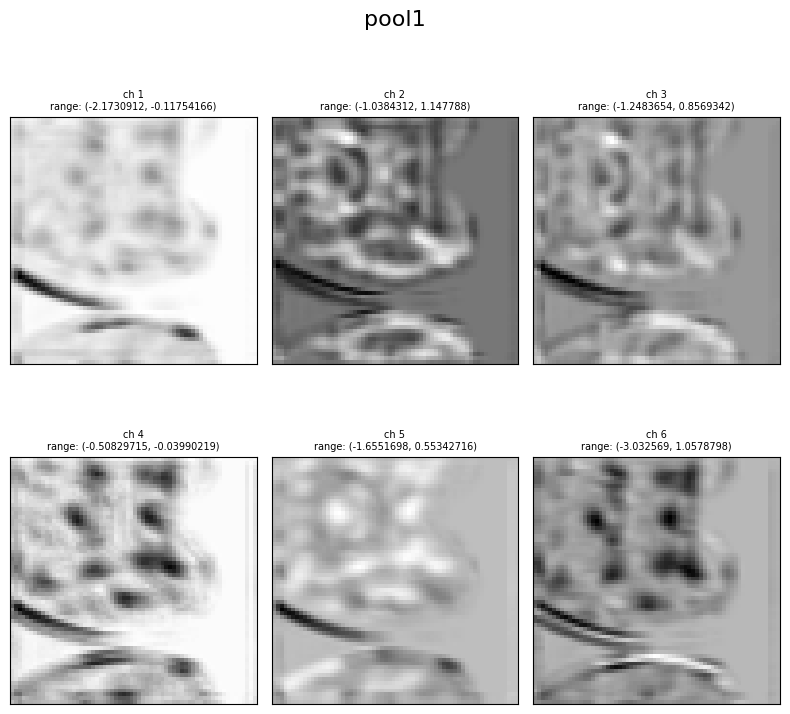

In [37]:

layer_names = ['conv1', 'relu1', 'pool1', 'conv2', 'relu2', 'pool2']
class_names = ['BooPadPongali', 'FriedKale', 'MassamanGai', 'PadPakBung']
batch, labels = next(iter(test_loader))

input_image = batch[0].unsqueeze(dim=0)
print(input_image.shape)
plt.imshow(input_image[0].permute(1, 2, 0))
print('label:',class_names[labels[0]])
feature_extractor = FeatureExtractor(model.eval(), layer_names)
feature_map = feature_extractor(input_image.to('cuda'))

for layer_name,feat in zip(layer_names,feature_map):
    visualize_feature_map(feat,layer_name)


# MODEL EVALUATION


In [38]:
def load_model(model,model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def plot_confusion_matrix(ax, cm, title, labels):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

def summary_confusion_matrix(model, class_names):
    model = model.cuda()
    true_labels = []
    predicted_labels = []
    for images, labels in test_loader:
        images = images.cuda()
        labels = torch.tensor(labels)

        with torch.no_grad():
            output = model(images)
            predicted = output.argmax(dim=1).cpu().numpy()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted)

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print(report)
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

<ipython-input-38-2becc8d7dae2>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


               precision    recall  f1-score   support

BooPadPongali       0.79      0.66      0.72        99
    FriedKale       0.82      0.73      0.78        94
  MassamanGai       0.67      0.83      0.75        72
   PadPakBung       0.62      0.76      0.69        46

     accuracy                           0.74       311
    macro avg       0.73      0.75      0.73       311
 weighted avg       0.75      0.74      0.74       311



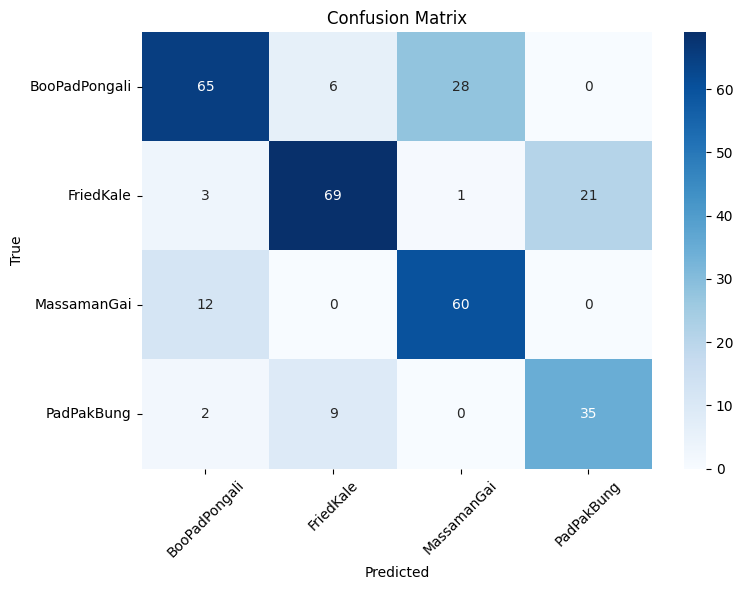

In [39]:
class_names = ['BooPadPongali', 'FriedKale', 'MassamanGai', 'PadPakBung']
summary_confusion_matrix(model, class_names)

In [40]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.0468,  0.0065, -0.0167,  0.0590, -0.0658],
                        [ 0.0422, -0.0154, -0.0341, -0.0395, -0.0530],
                        [-0.0361, -0.0884, -0.0114, -0.0970, -0.1105],
                        [ 0.0498, -0.0937, -0.0847,  0.0209,  0.0846],
                        [-0.1008, -0.0212, -0.0373, -0.0158, -0.1165]],
              
                       [[-0.0509,  0.0170,  0.0764, -0.1162, -0.0269],
                        [-0.0233,  0.0527, -0.0774,  0.0018, -0.0334],
                        [-0.0501, -0.1011, -0.0684,  0.0539,  0.0553],
                        [-0.1008,  0.0451,  0.0447, -0.0971,  0.0227],
                        [ 0.0459,  0.0563, -0.0482, -0.1212,  0.0390]],
              
                       [[-0.0327,  0.0186, -0.0353, -0.1246,  0.0330],
                        [-0.0722, -0.1235,  0.0057, -0.0642, -0.0449],
                        [ 0.0579,  0.0700, -0.1163, -0.0932, -0.1082],
               

In [43]:
model.state_dict()['fc2.weight'].shape, model.state_dict()['fc2.bias'].shape

(torch.Size([84, 120]), torch.Size([84]))

In [42]:
save_path = "foodfounder.pth"
torch.save(model.state_dict(), save_path)

---

# Exercise

‡πÉ‡∏´‡πâ‡∏ó‡∏î‡∏•‡∏≠‡∏á‡∏õ‡∏£‡∏±‡∏ö‡∏û‡∏≤‡∏£‡∏≤‡∏°‡∏¥‡πÄ‡∏ï‡∏≠‡∏£‡πå‡∏ï‡πà‡∏≠‡πÑ‡∏õ‡∏ô‡∏µ‡πâ ‡πÅ‡∏•‡πâ‡∏ß‡πÄ‡∏Ç‡∏µ‡∏¢‡∏ô‡∏≠‡∏ò‡∏¥‡∏ö‡∏≤‡∏¢‡∏ß‡πà‡∏≤‡∏ó‡∏≥‡∏≠‡∏∞‡πÑ‡∏£‡πÄ‡∏û‡∏¥‡πà‡∏°‡πÄ‡∏ï‡∏¥‡∏° ‡πÅ‡∏•‡∏∞‡∏°‡∏µ‡∏Å‡∏≤‡∏£‡πÄ‡∏õ‡∏•‡∏µ‡πà‡∏¢‡∏ô‡πÅ‡∏õ‡∏•‡∏á‡∏≠‡∏∞‡πÑ‡∏£‡πÄ‡∏Å‡∏¥‡∏î‡∏Ç‡∏∂‡πâ‡∏ô‡∏ö‡πâ‡∏≤‡∏á
1. LENET Model Architecture (‡πÄ‡∏ä‡πà‡∏ô node, layer, etc.)
2. training parameters (‡πÄ‡∏ä‡πà‡∏ô learning rate, optimizer, batch_size, etc.)

‡πÄ‡∏û‡∏∑‡πà‡∏≠‡πÉ‡∏´‡πâ‡πÑ‡∏î‡πâ Loss ‡∏ï‡πà‡∏≥‡∏ó‡∏µ‡πà‡∏™‡∏∏‡∏î ‡πÅ‡∏•‡∏∞ ‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ‡∏ó‡∏≥ Data Augment ‡πÄ‡∏û‡∏¥‡πà‡∏°‡πÄ‡∏ï‡∏¥‡∏°‡πÑ‡∏î‡πâ‡∏´‡∏≤‡∏Å‡∏à‡∏≥‡πÄ‡∏õ‡πá‡∏ô
‡∏Å‡∏≥‡∏´‡∏ô‡∏î‡πÉ‡∏´‡πâ‡πÉ‡∏ä‡πâ Performance metrics ‡πÄ‡∏õ‡πá‡∏ô F1-Score

***‡∏™‡∏¥‡πà‡∏á‡∏ó‡∏µ‡πà‡∏ï‡πâ‡∏≠‡∏á‡∏™‡πà‡∏á***
1. ‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏î‡∏™‡∏≠‡∏ö‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏Å‡∏±‡∏ö **Test dataset**\* ‡∏ó‡∏µ‡πà‡∏Å‡∏≥‡∏´‡∏ô‡∏î‡πÄ‡∏õ‡πá‡∏ô‡πÑ‡∏ü‡∏•‡πå `.csv` ‡∏õ‡∏£‡∏∞‡∏Å‡∏≠‡∏ö‡πÑ‡∏õ‡∏î‡πâ‡∏ß‡∏¢ 2 ‡∏Ñ‡∏≠‡∏•‡∏±‡∏°‡∏ô‡πå ([‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á‡πÑ‡∏ü‡∏•‡πå csv](https://github.com/NextGen-AI-Camp/curriculum/blob/main/Week%235/CNN%232/sample_submission.csv))
    - ‡∏Ñ‡∏≠‡∏•‡∏±‡∏°‡∏ô‡πå‡∏ó‡∏µ‡πà‡πà 1 ‡πÄ‡∏õ‡πá‡∏ô‡∏ä‡∏∑‡πà‡∏≠‡πÑ‡∏ü‡∏•‡πå‡∏£‡∏π‡∏õ‡∏ó‡∏µ‡πà‡πÉ‡∏ä‡πâ predict
    - ‡∏Ñ‡∏≠‡∏•‡∏±‡∏°‡∏ô‡πå‡∏ó‡∏µ‡πà 2 ‡πÄ‡∏õ‡πá‡∏ô‡∏ú‡∏•‡∏±‡∏û‡∏ò‡πå‡∏Å‡∏≤‡∏£ predict ‡∏à‡∏≤‡∏Å‡πÇ‡∏°‡πÄ‡∏î‡∏•

2. ‡πÑ‡∏ü‡∏•‡πå weight ‡∏Ç‡∏≠‡∏á‡πÇ‡∏°‡πÄ‡∏î‡∏• (`.pth` ‡∏´‡∏£‡∏∑‡∏≠ `.pt`)
3. ‡πÑ‡∏ü‡∏•‡πå source code (`.ipynb`)

***‡∏Å‡∏£‡∏∏‡∏ì‡∏≤‡∏™‡πà‡∏á‡πÑ‡∏ü‡∏•‡πå‡∏î‡∏±‡∏á‡∏ô‡∏µ‡πâ:***
- ‡πÑ‡∏ü‡∏•‡πå `.csv` ‡πÅ‡∏¢‡∏Å‡∏ï‡πà‡∏≤‡∏á‡∏´‡∏≤‡∏Å
- ‡πÑ‡∏ü‡∏•‡πå `.zip` ‡∏ó‡∏µ‡πà zip ‡πÑ‡∏ü‡∏•‡πå weight ‡∏Ç‡∏≠‡∏á‡πÇ‡∏°‡πÄ‡∏î‡∏• (`.pth` ‡∏´‡∏£‡∏∑‡∏≠ `.pt`) ‡πÅ‡∏•‡∏∞‡πÑ‡∏ü‡∏•‡πå source code (`.ipynb`)

***\*Note: Test dataset ‡∏à‡∏∞‡πÄ‡∏õ‡∏¥‡∏î public ‡∏ß‡∏±‡∏ô‡∏®‡∏∏‡∏Å‡∏£‡πå‡∏ó‡∏µ‡πà 2 ‡∏™‡∏Ñ. ‡πÄ‡∏ß‡∏•‡∏≤ 22.00 ‡∏ô.***